# Introduction

This is the notebook to analyse data for the manuscript (in progress): 

"Single cell mRNA signals reveal a distinct developmental state of KMT2A-rearranged infant B-lymphoblastic leukaemia".

1. <a href='#preprocess'>Preprocessing and filtering</a>
2. <a href='#cluster'>Clustering and UMAP</a>
3. <a href='#logreg'>Logistic regression</a>
4. <a href='#deconv'>Bulk RNA-seq deconvolution</a>

<a id='preprocess'></a>
Single cell data was collected and processed at 3 different timepoints.

1. Experiment 1: 
    - P1_iALLM_P2_iALLF_Dx_run1/run2: two channels of P1_iALL multiplexed with P2_iALL **diagnosis**
    - P9_iAML_Dx: one channel of P9_iAML
    - <em> new addition: P1_iALLM_P2_iALLF_Dx_run1/_run2: two channels of P1_iALL multiplexed with P2_iALL at **day 8**</em>

2. Experiment 2: 
    - P3_iALL_P10_iAML_Dx_run1/run2: one channels of P3_iALL multiplexed with P10_iAML
    - P4_iALL_Dx_run1/run2: two channels of P4_iALL
3. Experiment 3: one channel of P5_iALL multiplexed with classSwitch sample CS_iALL (not included in the analysis), one channel of P6_iALL, one channel of P7_iALL7_NUTM1 and one for P8_iALL8_ETV6

Raw fastq files were processed with with cellranger v3.0.2, which aligned the reads to reference genome (GRCh38 v1.2.0)  and produced matrix of gene expression per single cell.  
Ambient mRNA contamination was removed with SoupX package in R. Demultiplexing of InfALL1/InfALL2, InfALL3/InfAML2 and InfALL5/InfALL6 was performed with souporcell (https://doi.org/10.1038/s41592-020-0820-1) using following command:  
`singularity exec souporcell_latest.sif souporcell_pipeline.py -i possorted_genome_bam.bam -b barcodes.tsv -f genome.fa -t 20 -o souporcell_2 -k 2 --min_ref 4  --min_alt 4`

Souporcell produced clusters.tsv file that we can use to demultiplex data. Luckily for us, data was multiplexed for different genders so we can easily find out which demultiplexed sample belong to which patient using sex-specific genes such as XIST or y-specific genes such as  RPS4Y1, ZFY and couple of others.


Ok, let's load the data (after SoupX), demultiplex it and run some basic QC.  
We will start with two channels of P1_iALL multiplexed with P2_iALL:

First run: multiplexed P1_iALL_male with P2_iALL_female after SoupX have  1154  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical


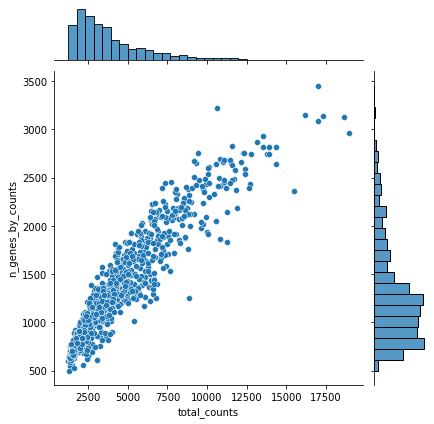

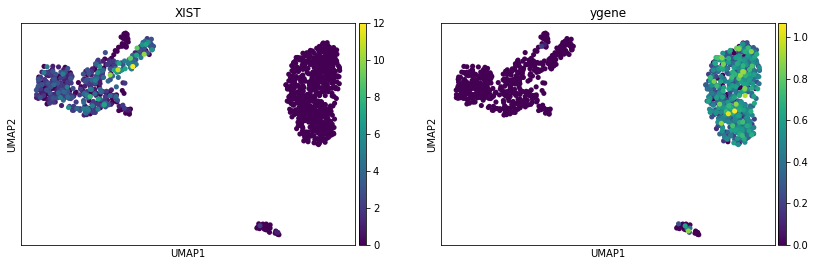

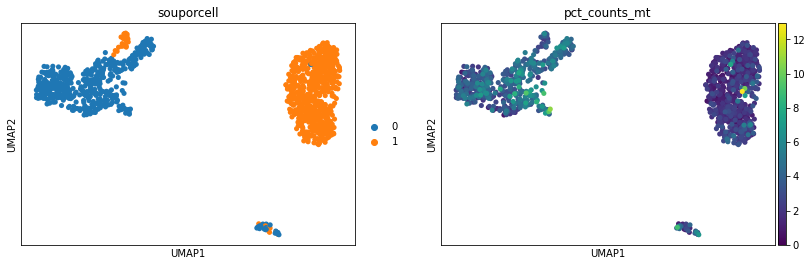

demultiplexed P1_iALLM in first run have  636  cells
demultiplexed P2_iALLF in first run have  499  cells


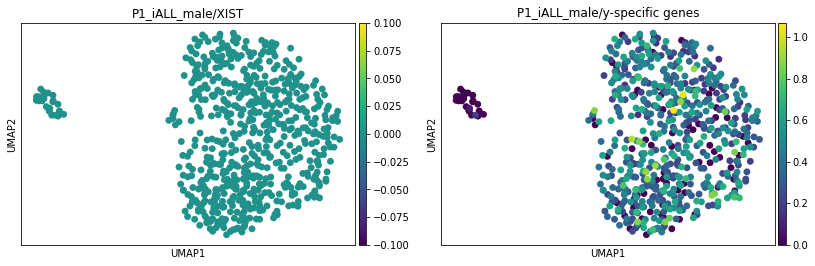

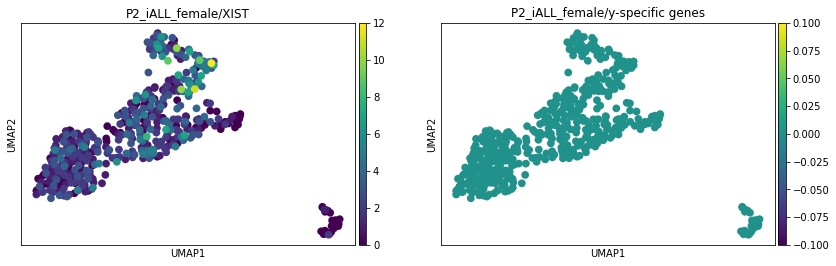

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns


mito_cutoff = 20

# Read SoupX processed data
adata1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_1/P1_iALLM_P2_iALLF_Dx_run1_strained/', var_names='gene_symbols')
adata1.raw = adata1
print('First run: multiplexed P1_iALL_male with P2_iALL_female after SoupX have ', adata1.shape[0], ' cells')
sc.pp.filter_cells(adata1, min_genes=200)
adata1.var['mt'] = adata1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata1 = adata1[adata1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.neighbors(adata1)
sc.tl.umap(adata1)
sorcell = pd.read_csv('data/single_cell_data/P1_iALLM_P2_iALLF_Dx_run1_clusters.tsv', sep = '\t', index_col=0)
sorcell = sorcell[sorcell.status == 'singlet']
adata1 = adata1[adata1.obs_names.isin(sorcell.index)].copy()

adata1.obs['souporcell'] = sorcell.assignment

# we use combination of Y-specific genes
adata1.obs['ygene']= np.mean(adata1[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata1, color = ['XIST', 'ygene'], ncols = 2)
sc.pl.umap(adata1, color = ['souporcell','pct_counts_mt'])

adataP1_iALLMrun1 = adata1[adata1.obs['souporcell'] == '1']
adataP2_iALLFrun1 = adata1[adata1.obs['souporcell'] == '0']
print('demultiplexed P1_iALLM in first run have ', adataP1_iALLMrun1.shape[0], ' cells')
print('demultiplexed P2_iALLF in first run have ', adataP2_iALLFrun1.shape[0], ' cells')

sc.pp.neighbors(adataP1_iALLMrun1)
sc.tl.umap(adataP1_iALLMrun1)

sc.pp.neighbors(adataP2_iALLFrun1)
sc.tl.umap(adataP2_iALLFrun1)

sc.pl.umap(adataP1_iALLMrun1, color = ['XIST', 'ygene'], ncols = 2, title = ['P1_iALL_male/XIST','P1_iALL_male/y-specific genes'])
sc.pl.umap(adataP2_iALLFrun1, color = ['XIST', 'ygene'], ncols = 2, title = ['P2_iALL_female/XIST','P2_iALL_female/y-specific genes'])


And now the same for second channel

Second run: multiplexed P1_iALL_male with P2_iALL_female after SoupX have  1209  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical


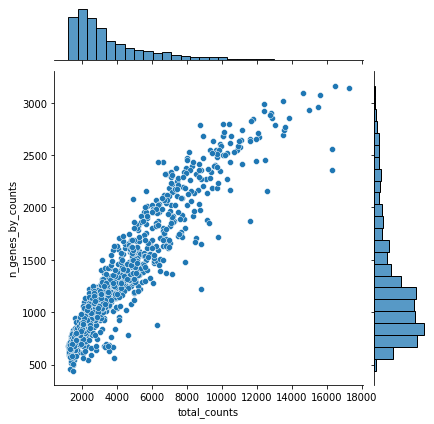

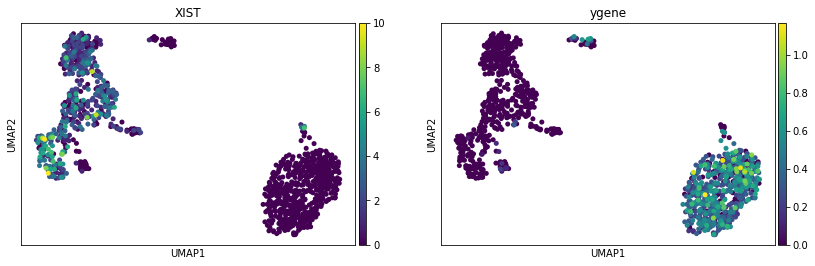

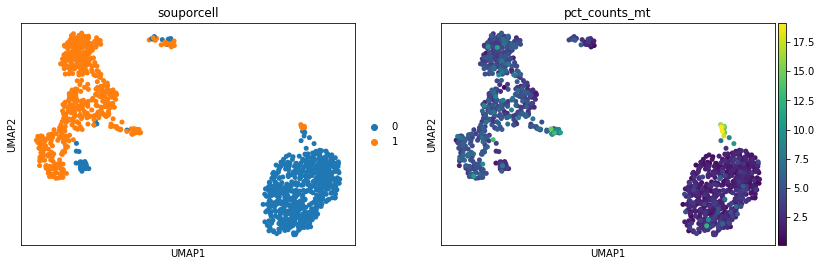

demultiplexed P1_iALLM in second run have  638  cells
demultiplexed P2_iALLF in second run have  548  cells


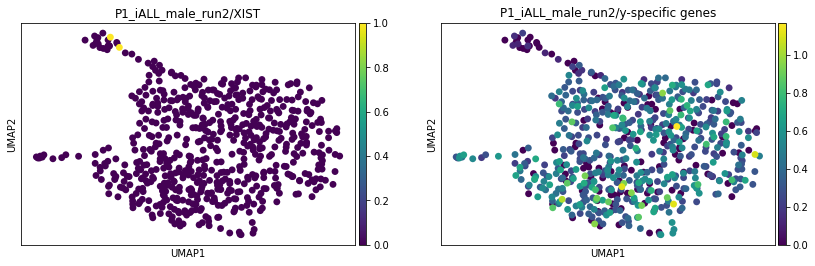

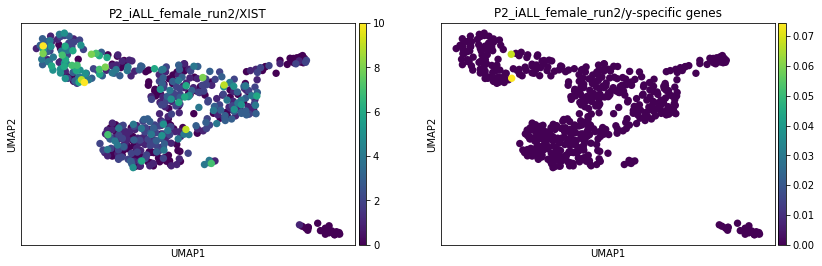

In [3]:
# Read SoupX processed data
adata2 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_1/P1_iALLM_P2_iALLF_Dx_run2_strained/', var_names='gene_symbols')
adata2.raw = adata2
print('Second run: multiplexed P1_iALL_male with P2_iALL_female after SoupX have ', adata2.shape[0], ' cells')
sc.pp.filter_cells(adata2, min_genes=200)
adata2.var['mt'] = adata2.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata2 = adata2[adata2.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata2.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sorcell = pd.read_csv('data/single_cell_data/P1_iALLM_P2_iALLF_Dx_run2_clusters.tsv', sep = '\t', index_col=0)
sorcell = sorcell[sorcell.status == 'singlet']
adata2 = adata2[adata2.obs_names.isin(sorcell.index)].copy()

adata2.obs['souporcell'] = sorcell.assignment

adata2.obs['ygene']= np.mean(adata2[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata2, color = ['XIST', 'ygene'], ncols = 2)
sc.pl.umap(adata2, color = ['souporcell','pct_counts_mt'])

adataP1_iALLMrun2 = adata2[adata2.obs['souporcell'] == '0']
adataP2_iALLFrun2 = adata2[adata2.obs['souporcell'] == '1']
print('demultiplexed P1_iALLM in second run have ', adataP1_iALLMrun2.shape[0], ' cells')
print('demultiplexed P2_iALLF in second run have ', adataP2_iALLFrun2.shape[0], ' cells')

sc.pp.neighbors(adataP1_iALLMrun2)
sc.tl.umap(adataP1_iALLMrun2)

sc.pp.neighbors(adataP2_iALLFrun2)
sc.tl.umap(adataP2_iALLFrun2)

sc.pl.umap(adataP1_iALLMrun2, color = ['XIST', 'ygene'], ncols = 2, title = ['P1_iALL_male_run2/XIST','P1_iALL_male_run2/y-specific genes'])
sc.pl.umap(adataP2_iALLFrun2, color = ['XIST', 'ygene'], ncols = 2, title = ['P2_iALL_female_run2/XIST','P2_iALL_female_run2/y-specific genes'])

We will combine single cell data from 2 channels into one object and save it as h5ad. AnnData object contains normalized and log processed data in adata.X slot but we can get raw counts back using following command:
`adata_RAW = adata.raw.to_adata()`

combining P1_iALL (male) from 2 channels:


... storing 'souporcell' as categorical


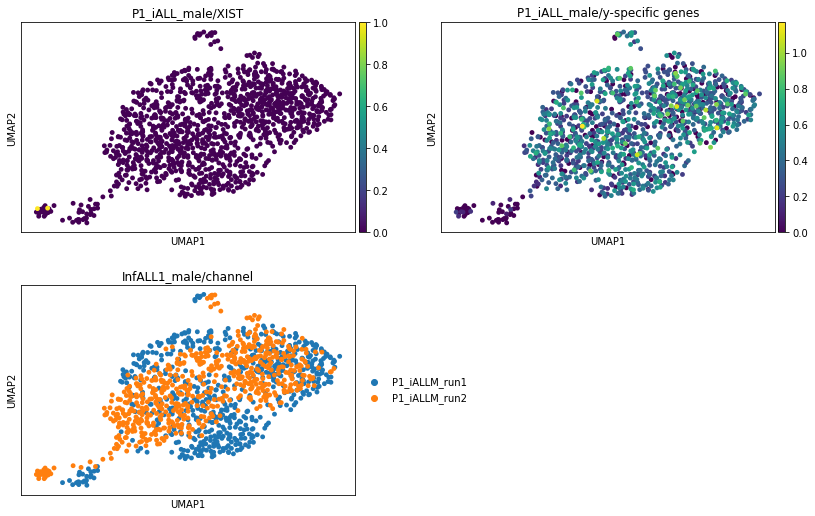

Combined P1_iALL (male) from both runs have  1274  cells
combining P2_iALL (female) from 2 channels:


... storing 'souporcell' as categorical


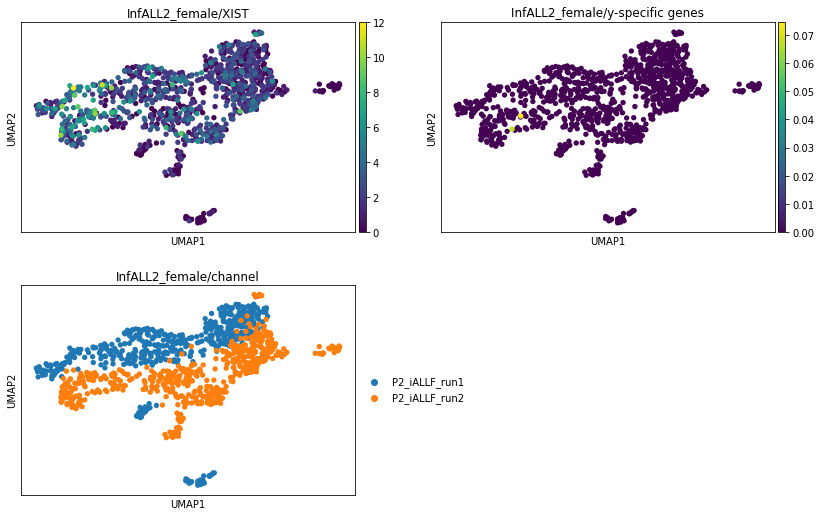

Combined P2_iALL (female) from both runs have  1047  cells


In [4]:
from scipy import io

print('combining P1_iALL (male) from 2 channels:')
adata_P1_iALL = adataP1_iALLMrun1.concatenate(adataP1_iALLMrun2, batch_categories=['P1_iALLM_run1', 'P1_iALLM_run2'])
sc.pp.neighbors(adata_P1_iALL)
sc.tl.umap(adata_P1_iALL)
sc.pl.umap(adata_P1_iALL, color = ['XIST', 'ygene', 'batch'], ncols = 2, title = ['P1_iALL_male/XIST','P1_iALL_male/y-specific genes', 'InfALL1_male/channel'])
print('Combined P1_iALL (male) from both runs have ', adata_P1_iALL.shape[0], ' cells')
#adata_P1_iALL.write_h5ad('data/single_cell_data/final_h5ad/P1_iALLM_Dx_combined_RAW.h5ad')

print('combining P2_iALL (female) from 2 channels:')
adata_P2_iALL = adataP2_iALLFrun1.concatenate(adataP2_iALLFrun2, batch_categories=['P2_iALLF_run1', 'P2_iALLF_run2'])
sc.pp.neighbors(adata_P2_iALL)
sc.tl.umap(adata_P2_iALL)
sc.pl.umap(adata_P2_iALL, color = ['XIST', 'ygene', 'batch'], ncols = 2, title = ['InfALL2_female/XIST','InfALL2_female/y-specific genes', 'InfALL2_female/channel'])
print('Combined P2_iALL (female) from both runs have ', adata_P2_iALL.shape[0], ' cells')
#adata_P2_iALL.write_h5ad('data/single_cell_data/final_h5ad/P2_iALLF_Dx_combined_RAW.h5ad')

Let's process another sample from the first experiment: P9_iAML

P9_iAML after SoupX have  1209  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


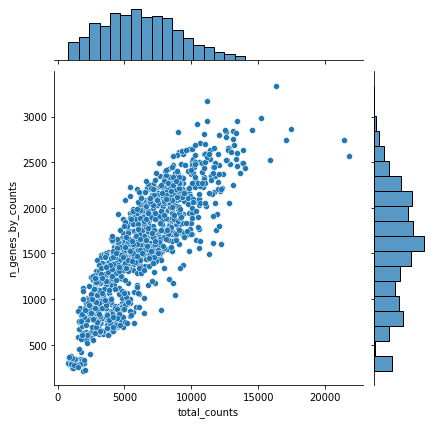

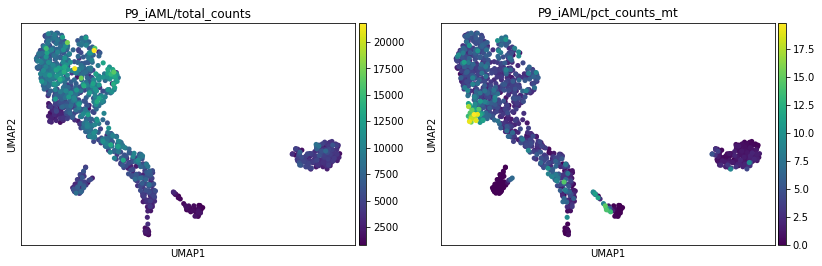

After filtering and preprocessing P9_iAML have  1149  cells


In [5]:
# Read SoupX processed data
adata_P9_iAML = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_1/P9_iAML_Dx_strained/', var_names='gene_symbols')
adata_P9_iAML.raw = adata_P9_iAML
adata_P9_iAML.obs_names = adata_P9_iAML.obs_names+'-P9_iAML'
print('P9_iAML after SoupX have ', adata_P9_iAML.shape[0], ' cells')
sc.pp.filter_cells(adata_P9_iAML, min_genes=200)
adata_P9_iAML.var['mt'] = adata_P9_iAML.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_P9_iAML, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_P9_iAML = adata_P9_iAML[adata_P9_iAML.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_P9_iAML.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_P9_iAML, counts_per_cell_after=1e4)
sc.pp.log1p(adata_P9_iAML)
sc.pp.neighbors(adata_P9_iAML)
sc.tl.umap(adata_P9_iAML)
sc.pl.umap(adata_P9_iAML, color = ['total_counts','pct_counts_mt'], title = ['P9_iAML/total_counts','P9_iAML/pct_counts_mt'])

print('After filtering and preprocessing P9_iAML have ', adata_P9_iAML.shape[0], ' cells')
#adata_P9_iAML.write_h5ad('data/single_cell_data/final_h5ad/P9_iAML_Dx_RAW.h5ad')

And now the last sample: InfALL1 and InfALL2 at **day 8**:

First run: multiplexed P1_iALL_DAY8_male with P2_iALL_DAY8_female after SoupX have  1608  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical


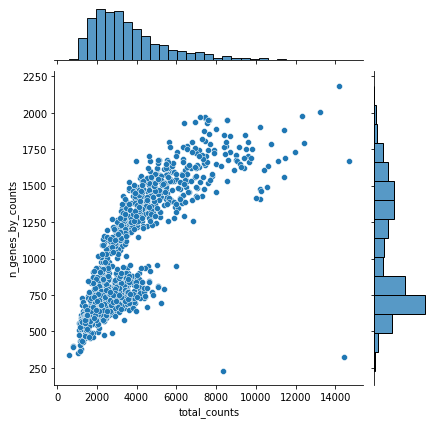

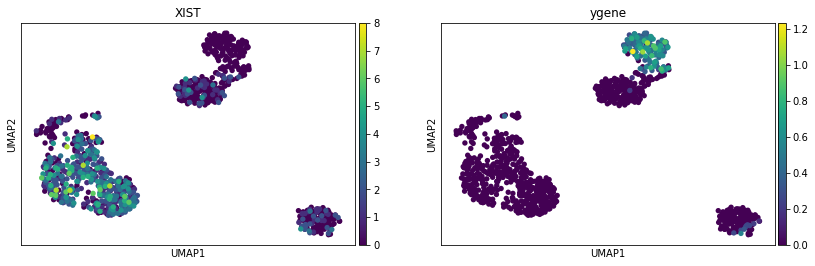

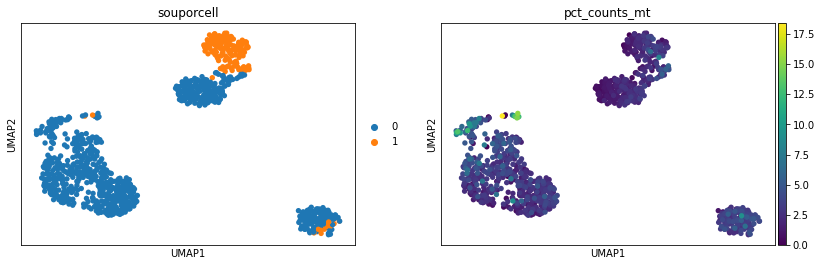

demultiplexed P1_iALLM in first run have  173  cells
demultiplexed P2_iALLF in first run have  863  cells


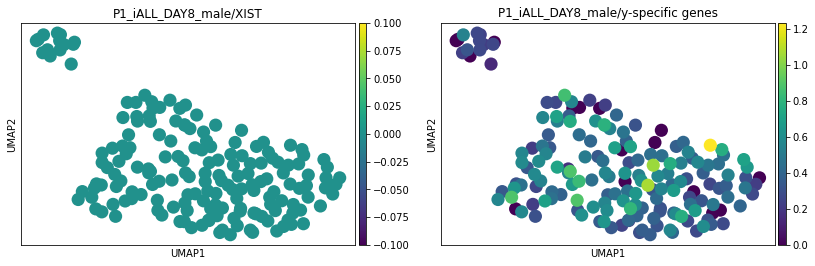

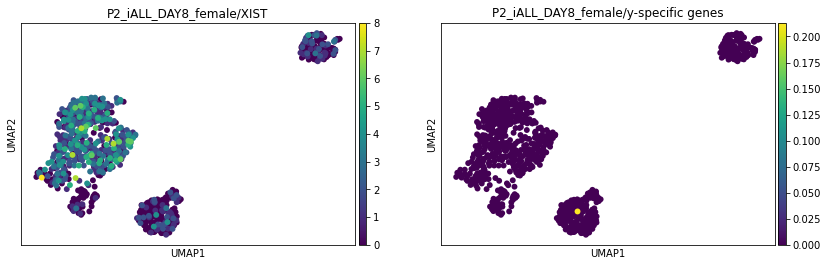

Second run: multiplexed P1_iALL_DAY8_male with P2_iALL_DAY8_female after SoupX have  1315  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical


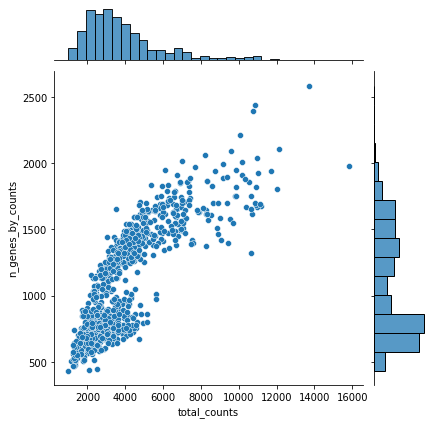

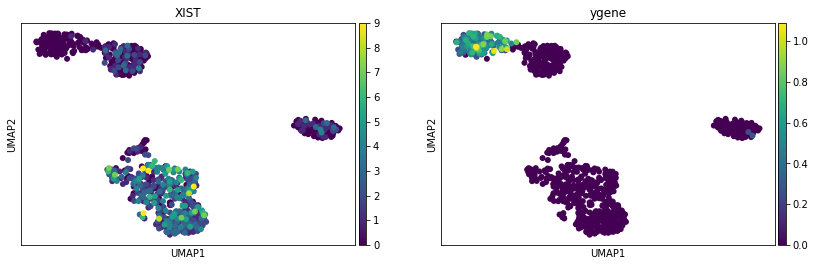

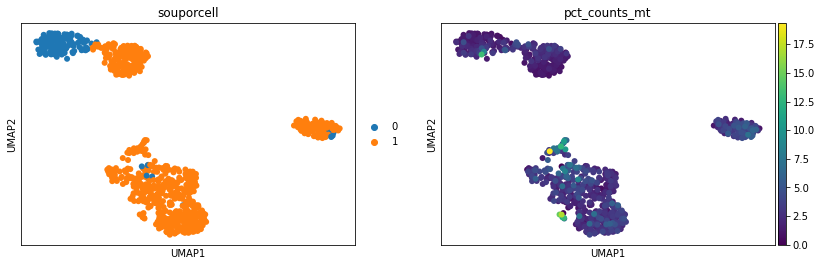

demultiplexed P1_iALLM in second run have  142  cells
demultiplexed P2_iALLF in second run have  697  cells


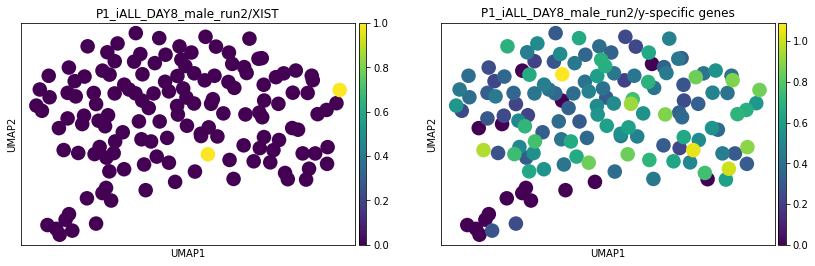

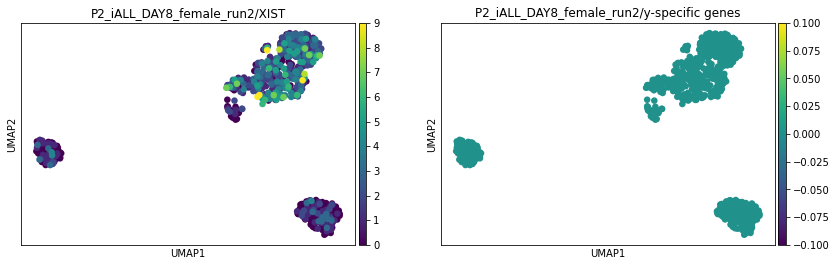

combining P1_iALL DAY8(male) from 2 channels:


... storing 'souporcell' as categorical


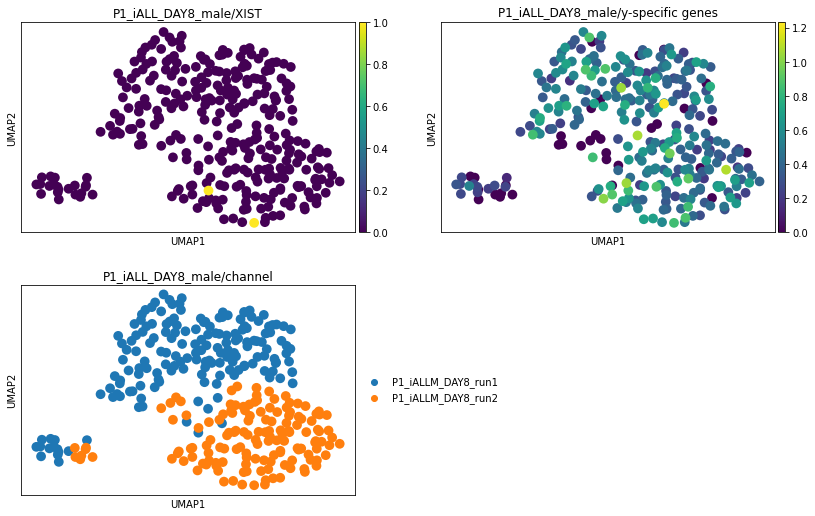

Combined P1_iALL DAY8(male) from both runs have  315  cells
combining P2_iALL DAY8(female) from 2 channels:


... storing 'souporcell' as categorical


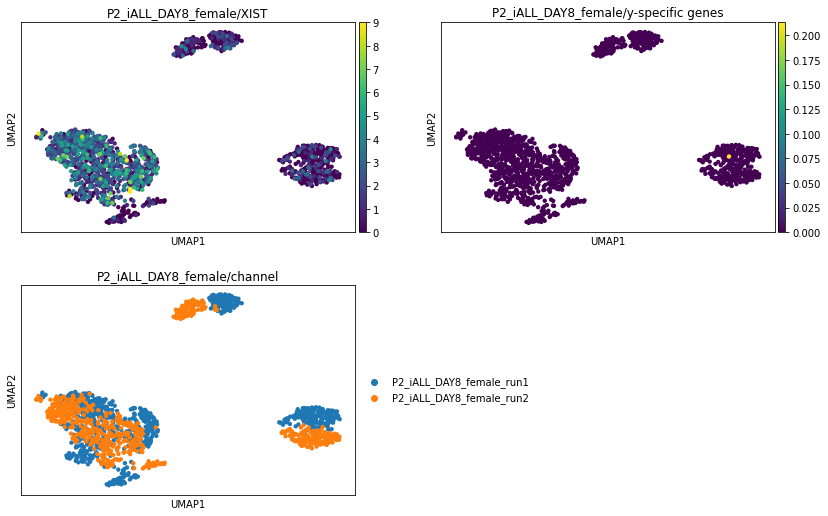

Combined P2_iALL DAY8 (female) from both runs have  1560  cells


In [6]:
# RUN 1
# Read SoupX processed data
adata1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_1/P1_iALLM_P2_iALLF_DAY8_run1_strained/', var_names='gene_symbols', cache=True)
adata1.raw = adata1
print('First run: multiplexed P1_iALL_DAY8_male with P2_iALL_DAY8_female after SoupX have ', adata1.shape[0], ' cells')
sc.pp.filter_cells(adata1, min_genes=200)
adata1.var['mt'] = adata1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata1 = adata1[adata1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.neighbors(adata1)
sc.tl.umap(adata1)
sorcell = pd.read_csv('data/single_cell_data/P1_iALLM_P2_iALLF_DAY8_run1_clusters.tsv', sep = '\t', index_col=0)
sorcell = sorcell[sorcell.status == 'singlet']
adata1 = adata1[adata1.obs_names.isin(sorcell.index)].copy()

adata1.obs['souporcell'] = sorcell.assignment

# we use combination of Y-specific genes
adata1.obs['ygene']= np.mean(adata1[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata1, color = ['XIST', 'ygene'], ncols = 2)
sc.pl.umap(adata1, color = ['souporcell','pct_counts_mt'])

adataP1_iALLM_DAY8_run1 = adata1[adata1.obs['souporcell'] == '1']
adataP2_iALLF_DAY8_run1 = adata1[adata1.obs['souporcell'] == '0']
print('demultiplexed P1_iALLM in first run have ', adataP1_iALLM_DAY8_run1.shape[0], ' cells')
print('demultiplexed P2_iALLF in first run have ', adataP2_iALLF_DAY8_run1.shape[0], ' cells')

sc.pp.neighbors(adataP1_iALLM_DAY8_run1)
sc.tl.umap(adataP1_iALLM_DAY8_run1)

sc.pp.neighbors(adataP2_iALLF_DAY8_run1)
sc.tl.umap(adataP2_iALLF_DAY8_run1)

sc.pl.umap(adataP1_iALLM_DAY8_run1, color = ['XIST', 'ygene'], ncols = 2, title = ['P1_iALL_DAY8_male/XIST','P1_iALL_DAY8_male/y-specific genes'])
sc.pl.umap(adataP2_iALLF_DAY8_run1, color = ['XIST', 'ygene'], ncols = 2, title = ['P2_iALL_DAY8_female/XIST','P2_iALL_DAY8_female/y-specific genes'])



# RUN 2

# Read SoupX processed data
adata2 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_1/P1_iALLM_P2_iALLF_DAY8_run2_strained/', var_names='gene_symbols', cache=True)
adata2.raw = adata2
print('Second run: multiplexed P1_iALL_DAY8_male with P2_iALL_DAY8_female after SoupX have ', adata2.shape[0], ' cells')
sc.pp.filter_cells(adata2, min_genes=200)
adata2.var['mt'] = adata2.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata2 = adata2[adata2.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata2.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sorcell = pd.read_csv('data/single_cell_data/P1_iALLM_P2_iALLF_DAY8_run2_clusters.tsv', sep = '\t', index_col=0)
sorcell = sorcell[sorcell.status == 'singlet']
adata2 = adata2[adata2.obs_names.isin(sorcell.index)].copy()

adata2.obs['souporcell'] = sorcell.assignment

adata2.obs['ygene']= np.mean(adata2[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata2, color = ['XIST', 'ygene'], ncols = 2)
sc.pl.umap(adata2, color = ['souporcell','pct_counts_mt'])

adataP1_iALLM_DAY8_run2 = adata2[adata2.obs['souporcell'] == '0']
adataP2_iALLF_DAY8_run2 = adata2[adata2.obs['souporcell'] == '1']
print('demultiplexed P1_iALLM in second run have ', adataP1_iALLM_DAY8_run2.shape[0], ' cells')
print('demultiplexed P2_iALLF in second run have ', adataP2_iALLF_DAY8_run2.shape[0], ' cells')

sc.pp.neighbors(adataP1_iALLM_DAY8_run2)
sc.tl.umap(adataP1_iALLM_DAY8_run2)

sc.pp.neighbors(adataP2_iALLF_DAY8_run2)
sc.tl.umap(adataP2_iALLF_DAY8_run2)

sc.pl.umap(adataP1_iALLM_DAY8_run2, color = ['XIST', 'ygene'], ncols = 2, title = ['P1_iALL_DAY8_male_run2/XIST','P1_iALL_DAY8_male_run2/y-specific genes'])
sc.pl.umap(adataP2_iALLF_DAY8_run2, color = ['XIST', 'ygene'], ncols = 2, title = ['P2_iALL_DAY8_female_run2/XIST','P2_iALL_DAY8_female_run2/y-specific genes'])


# COMBINE 2 RUNS

print('combining P1_iALL DAY8(male) from 2 channels:')
adata_P1_iALL_DAY8 = adataP1_iALLM_DAY8_run1.concatenate(adataP1_iALLM_DAY8_run2, batch_categories=['P1_iALLM_DAY8_run1', 'P1_iALLM_DAY8_run2'])
sc.pp.neighbors(adata_P1_iALL_DAY8)
sc.tl.umap(adata_P1_iALL_DAY8)
sc.pl.umap(adata_P1_iALL_DAY8, color = ['XIST', 'ygene', 'batch'], ncols = 2, title = ['P1_iALL_DAY8_male/XIST','P1_iALL_DAY8_male/y-specific genes', 'P1_iALL_DAY8_male/channel'])
print('Combined P1_iALL DAY8(male) from both runs have ', adata_P1_iALL_DAY8.shape[0], ' cells')
#adata_P1_iALL_DAY8.write_h5ad('data/single_cell_data/final_h5ad/P1_iALLM_DAY8_combined_RAW.h5ad')

print('combining P2_iALL DAY8(female) from 2 channels:')
adata_P2_iALL_DAY8 = adataP2_iALLF_DAY8_run1.concatenate(adataP2_iALLF_DAY8_run2, batch_categories=['P2_iALL_DAY8_female_run1', 'P2_iALL_DAY8_female_run2'])
sc.pp.neighbors(adata_P2_iALL_DAY8)
sc.tl.umap(adata_P2_iALL_DAY8)
sc.pl.umap(adata_P2_iALL_DAY8, color = ['XIST', 'ygene', 'batch'], ncols = 2, title = ['P2_iALL_DAY8_female/XIST','P2_iALL_DAY8_female/y-specific genes', 'P2_iALL_DAY8_female/channel'])
print('Combined P2_iALL DAY8 (female) from both runs have ', adata_P2_iALL_DAY8.shape[0], ' cells')
#adata_P2_iALL_DAY8.write_h5ad('data/single_cell_data/final_h5ad/P2_iALLF_DAY8_combined_RAW.h5ad')


# Experiment #2

In this experiment we have one channel (runs) of P3_iALL multiplexed with P10_iAML and two channels of P4_iALL. We will process them in the same way as other data.

Let's start with first run of mutiplexed data:

Multiplexed P3_iALL with P10_iAML after SoupX have  1119  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical


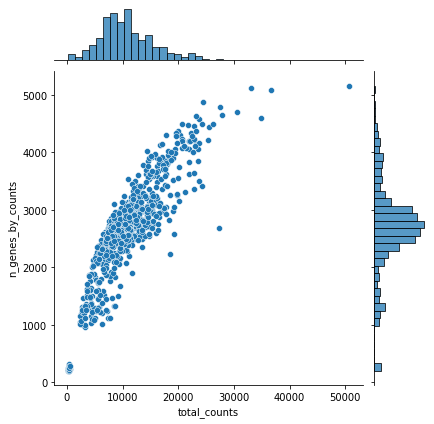

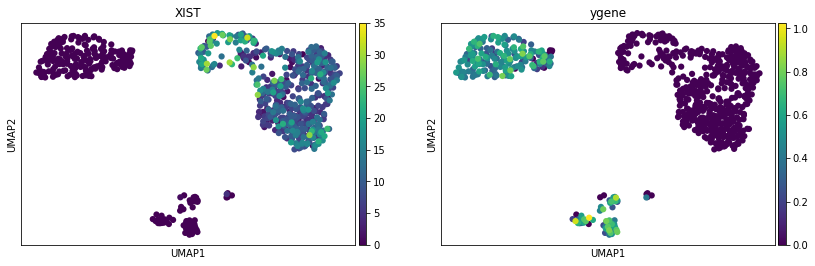

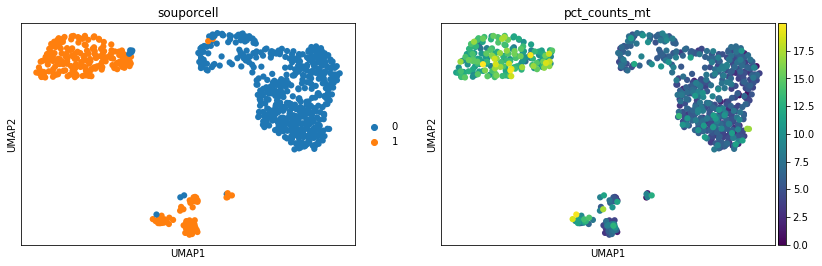

demultiplexed P10_iAML (male) have  250  cells
demultiplexed P3_iALL (female) have  521  cells


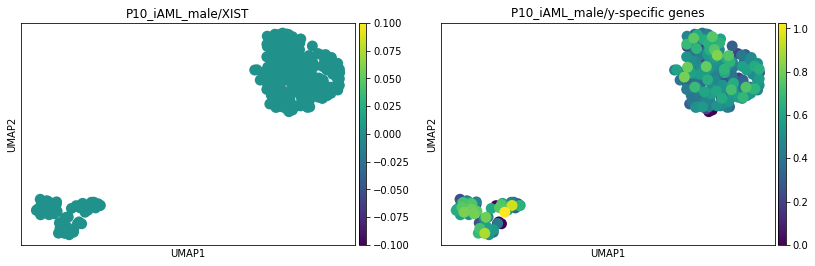

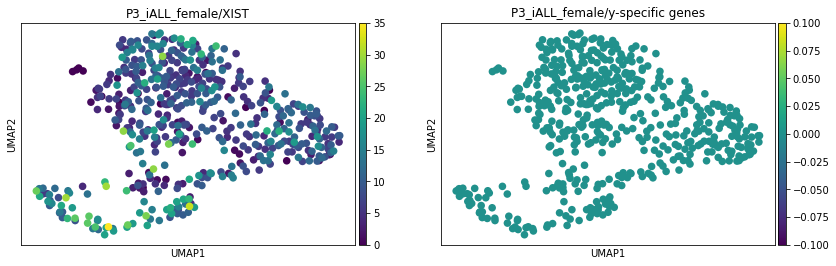

After filtering and preprocessing P10_iAML have  250  cells
After filtering and preprocessing P3_iALL have  521  cells


In [7]:
# Read SoupX processed data
adata1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_2/P3_iALL_P10_iAML_Dx_run1_strained/', var_names='gene_symbols')
adata1.raw = adata1
print('Multiplexed P3_iALL with P10_iAML after SoupX have ', adata1.shape[0], ' cells')
sc.pp.filter_cells(adata1, min_genes=200)
adata1.var['mt'] = adata1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata1 = adata1[adata1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.neighbors(adata1)
sc.tl.umap(adata1)
sorcell = pd.read_csv('data/single_cell_data/P3_iALL_P10_iAML_Dx_run1_clusters.tsv', sep = '\t', index_col=0)
sorcell = sorcell[sorcell.status == 'singlet']
adata1 = adata1[adata1.obs_names.isin(sorcell.index)].copy()

adata1.obs['souporcell'] = sorcell.assignment

adata1.obs['ygene']= np.mean(adata1[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata1, color = ['XIST', 'ygene'], ncols = 2)
sc.pl.umap(adata1, color = ['souporcell','pct_counts_mt'])

adata_P10_iAML_male = adata1[adata1.obs['souporcell'] == '1']
adata_P10_iAML_male.obs_names = adata_P10_iAML_male.obs_names+'-P10_iAML'

adata_P3_iALL_female = adata1[adata1.obs['souporcell'] == '0']
adata_P3_iALL_female.obs_names = adata_P3_iALL_female.obs_names+'-P3_iALL'

print('demultiplexed P10_iAML (male) have ', adata_P10_iAML_male.shape[0], ' cells')
print('demultiplexed P3_iALL (female) have ', adata_P3_iALL_female.shape[0], ' cells')

sc.pp.neighbors(adata_P10_iAML_male)
sc.tl.umap(adata_P10_iAML_male)

sc.pp.neighbors(adata_P3_iALL_female)
sc.tl.umap(adata_P3_iALL_female)

sc.pl.umap(adata_P10_iAML_male, color = ['XIST', 'ygene'], ncols = 2, title = ['P10_iAML_male/XIST','P10_iAML_male/y-specific genes'])
sc.pl.umap(adata_P3_iALL_female, color = ['XIST', 'ygene'], ncols = 2, title = ['P3_iALL_female/XIST','P3_iALL_female/y-specific genes'])

print('After filtering and preprocessing P10_iAML have ', adata_P10_iAML_male.shape[0], ' cells')
#adata_P10_iAML_male.write_h5ad('data/single_cell_data/final_h5ad/P10_iAML_Dx_RAW.h5ad')

print('After filtering and preprocessing P3_iALL have ', adata_P3_iALL_female.shape[0], ' cells')
#adata_P3_iALL_female.write_h5ad('data/single_cell_data/final_h5ad/P3_iALL_Dx_RAW.h5ad')


And now load the data for P4_iALL:

First run: P4_iALL after SoupX have  466  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


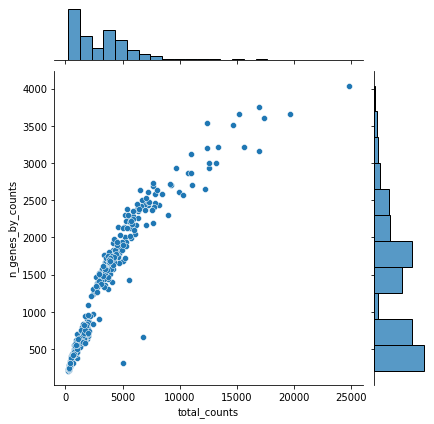

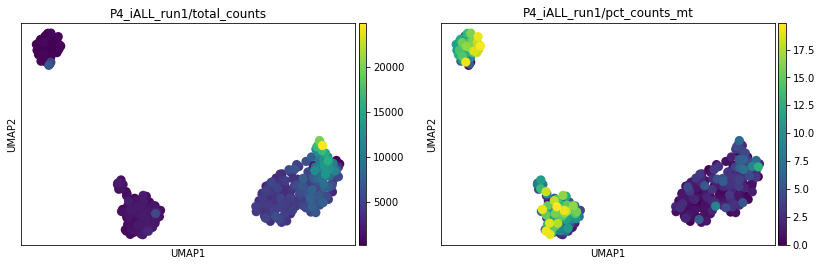

Second run: P4_iALL after SoupX have  370  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


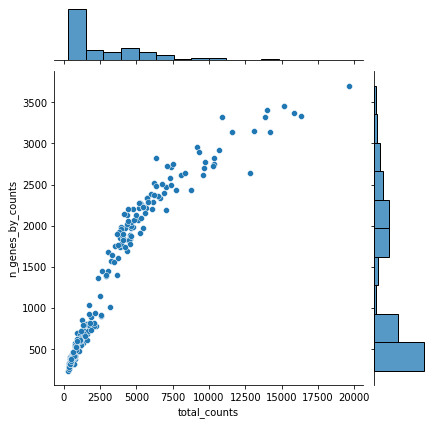

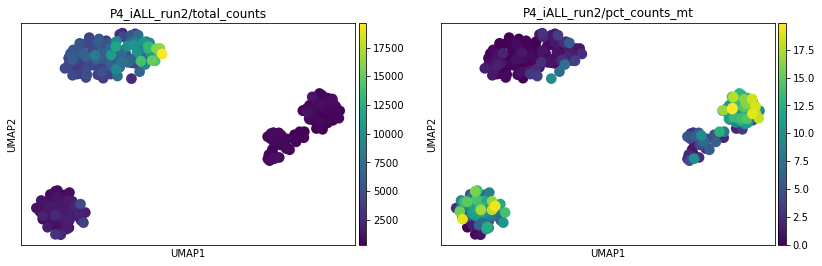

P4_iALL: two channels combined have  616  cells


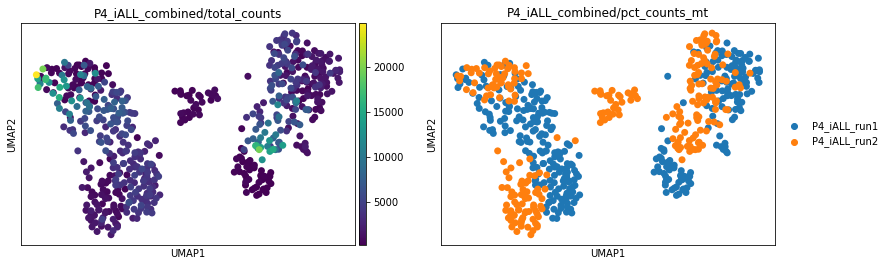

In [8]:
# Read SoupX processed data

adata1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_2/P4_iALL_Dx_run1_strained/', var_names='gene_symbols')
adata1.raw = adata1
print('First run: P4_iALL after SoupX have ', adata1.shape[0], ' cells')
sc.pp.filter_cells(adata1, min_genes=200)
adata1.var['mt'] = adata1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata1 = adata1[adata1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
sc.pp.log1p(adata1)
sc.pp.neighbors(adata1)
sc.tl.umap(adata1)
sc.pl.umap(adata1, color = ['total_counts','pct_counts_mt'], title = ['P4_iALL_run1/total_counts','P4_iALL_run1/pct_counts_mt'])


adata2 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_2/P4_iALL_Dx_run2_strained/', var_names='gene_symbols')
adata2.raw = adata2
print('Second run: P4_iALL after SoupX have ', adata2.shape[0], ' cells')
sc.pp.filter_cells(adata2, min_genes=200)
adata2.var['mt'] = adata2.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata2 = adata2[adata2.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata2.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.pl.umap(adata2, color = ['total_counts','pct_counts_mt'], title = ['P4_iALL_run2/total_counts','P4_iALL_run2/pct_counts_mt'])


adata_P4_iALL = adata1.concatenate(adata2, batch_categories = ['P4_iALL_run1', 'P4_iALL_run2'])
print('P4_iALL: two channels combined have ', adata_P4_iALL.shape[0], ' cells')
sc.pp.neighbors(adata_P4_iALL)
sc.tl.umap(adata_P4_iALL)
sc.pl.umap(adata_P4_iALL, color = ['total_counts','batch'], title = ['P4_iALL_combined/total_counts','P4_iALL_combined/pct_counts_mt'])

#adata_P4_iALL.write_h5ad('data/single_cell_data/final_h5ad/P4_iALL_Dx_RAW.h5ad')


# Experiment 3
This experiment consisted of one channel for P5_iALL multiplexed with CS_iALL (class switch case), one channel of each of: P6_iALL, P7_iALL7_NUTM1 and P8_iALL_ETV6

CS_iALL was not included in the analysis later on so we will ignore it. P5_iALL is female so we will extract the cells with cluster id corresponding to the expression of XIST.

Multiplexed P5_iALL with CS_iALL after SoupX have  3232  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'souporcell' as categorical


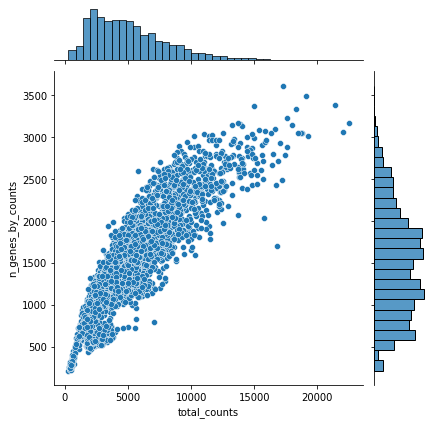

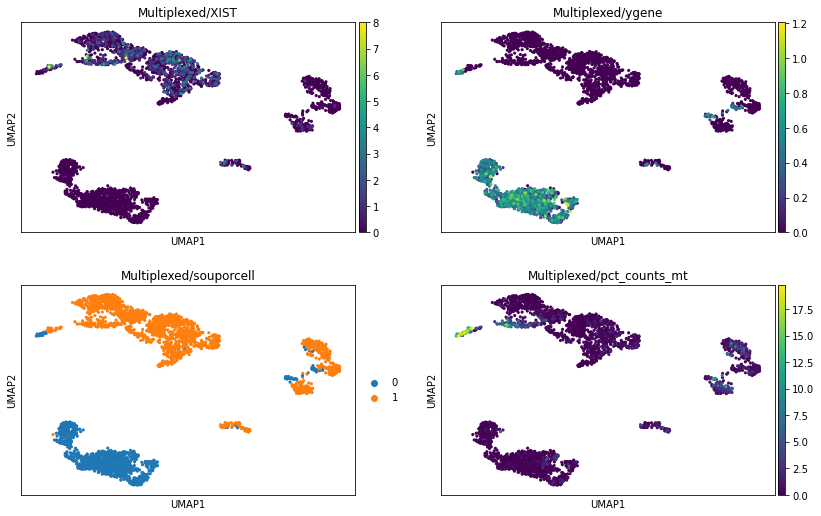

demultiplexed P5_iALL (female) have  1878  cells


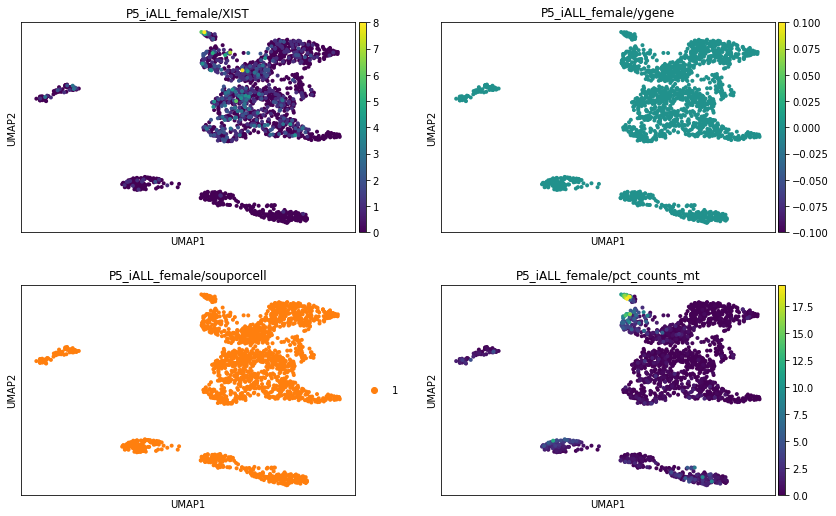

In [9]:
adata = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/P5_iALL_CS_iALL_L826_LK387_strained/')
adata.raw = adata
print('Multiplexed P5_iALL with CS_iALL after SoupX have ', adata.shape[0], ' cells')

sc.pp.filter_cells(adata, min_genes=200)
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata = adata[adata.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sorc = pd.read_csv('data/single_cell_data/P5_iALL_CS_iALL_L826_LK387_clusters.csv', sep = '\t',index_col=0)
sorc = sorc[sorc.status == 'singlet']
adata = adata[adata.obs_names.isin(sorc.index)].copy()

adata.obs['souporcell'] = sorc.assignment
adata.obs['ygene']= np.mean(adata[:, ['RPS4Y1', 'ZFY', 'DDX3Y', 'UTY', 'TMSB4Y', 'KDM5D', 'EIF1AY']].X, 1)

sc.pl.umap(adata, color = ['XIST', 'ygene', 'souporcell','pct_counts_mt'], ncols = 2, 
           title = ['Multiplexed/XIST', 'Multiplexed/ygene', 'Multiplexed/souporcell','Multiplexed/pct_counts_mt'])

adata_P5_iALL = adata[adata.obs.souporcell == '1'].copy() #LK387 female infant KMT2A B-ALL
adata_P5_iALL.obs_names = adata_P5_iALL.obs_names+'-P5_iALL'

print('demultiplexed P5_iALL (female) have ', adata_P5_iALL.shape[0], ' cells')

sc.pp.neighbors(adata_P5_iALL)
sc.tl.umap(adata_P5_iALL)
sc.pl.umap(adata_P5_iALL, color = ['XIST', 'ygene', 'souporcell','pct_counts_mt'], ncols = 2,
          title = ['P5_iALL_female/XIST', 'P5_iALL_female/ygene', 'P5_iALL_female/souporcell','P5_iALL_female/pct_counts_mt'])

#adata_P5_iALL.write_h5ad('data/single_cell_data/final_h5ad/P5_iALL_Dx_RAW.h5ad')


Now the same preprocessing for other samples

P6_iALL after SoupX have  8175  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


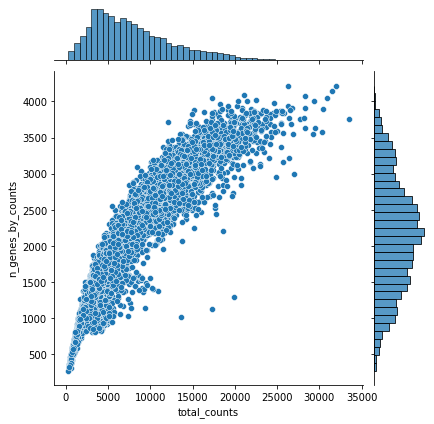

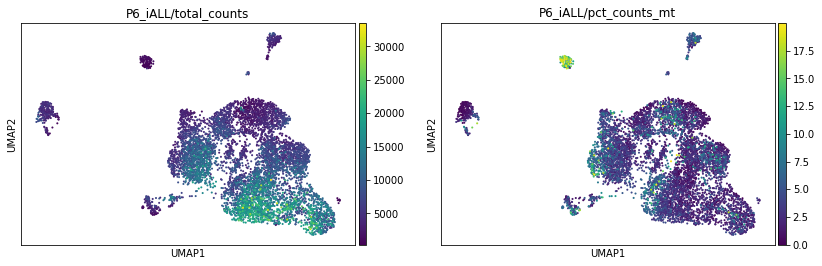

After filtering and preprocessing P6_iALL have  7141  cells


In [10]:
# Read SoupX processed data
adata_P6_iALL = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/P6_iALL_L876_Dx_strained/', var_names='gene_symbols')
adata_P6_iALL.raw = adata_P6_iALL
adata_P6_iALL.obs_names = adata_P6_iALL.obs_names+'-P6_iALL'

print('P6_iALL after SoupX have ', adata_P6_iALL.shape[0], ' cells')
sc.pp.filter_cells(adata_P6_iALL, min_genes=200)
adata_P6_iALL.var['mt'] = adata_P6_iALL.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_P6_iALL, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_P6_iALL = adata_P6_iALL[adata_P6_iALL.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_P6_iALL.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_P6_iALL, counts_per_cell_after=1e4)
sc.pp.log1p(adata_P6_iALL)
sc.pp.neighbors(adata_P6_iALL)
sc.tl.umap(adata_P6_iALL)
sc.pl.umap(adata_P6_iALL, color = ['total_counts','pct_counts_mt'], title = ['P6_iALL/total_counts','P6_iALL/pct_counts_mt'])

print('After filtering and preprocessing P6_iALL have ', adata_P6_iALL.shape[0], ' cells')
#adata_P6_iALL.write_h5ad('data/single_cell_data/final_h5ad/P6_iALL_Dx_RAW.h5ad')


P7_iALL_NUTM1 after SoupX have  6805  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


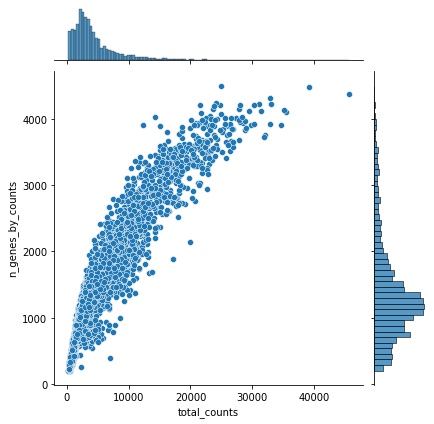

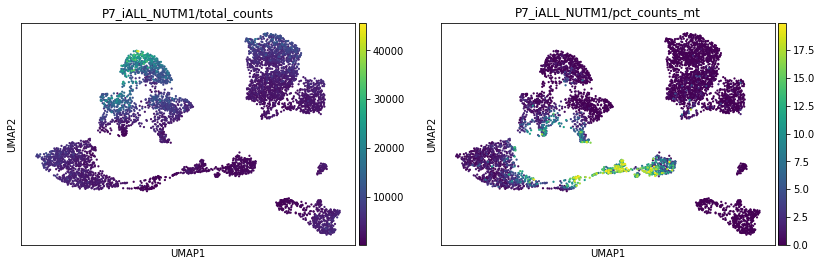

After filtering and preprocessing P7_iALL_NUTM1 have  6017  cells


In [12]:
# Read SoupX processed data
adata_P7_NUTM1 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/P7_iALL_NUTM1_Jacks_Dx_strained/', var_names='gene_symbols')
adata_P7_NUTM1.raw = adata_P7_NUTM1
adata_P7_NUTM1.obs_names = adata_P7_NUTM1.obs_names+'-P7_iALL_NUTM1'

print('P7_iALL_NUTM1 after SoupX have ', adata_P7_NUTM1.shape[0], ' cells')
sc.pp.filter_cells(adata_P7_NUTM1, min_genes=200)
adata_P7_NUTM1.var['mt'] = adata_P7_NUTM1.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_P7_NUTM1, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_P7_NUTM1 = adata_P7_NUTM1[adata_P7_NUTM1.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_P7_NUTM1.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_P7_NUTM1, counts_per_cell_after=1e4)
sc.pp.log1p(adata_P7_NUTM1)
sc.pp.neighbors(adata_P7_NUTM1)
sc.tl.umap(adata_P7_NUTM1)
sc.pl.umap(adata_P7_NUTM1, color = ['total_counts','pct_counts_mt'], title = ['P7_iALL_NUTM1/total_counts','P7_iALL_NUTM1/pct_counts_mt'])

print('After filtering and preprocessing P7_iALL_NUTM1 have ', adata_P7_NUTM1.shape[0], ' cells')
#adata_P7_NUTM1.write_h5ad('data/single_cell_data/final_h5ad/P7_iALL_NUTM1_Dx_RAW.h5ad')

P8_iALL_ETV6 after SoupX have  9199  cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


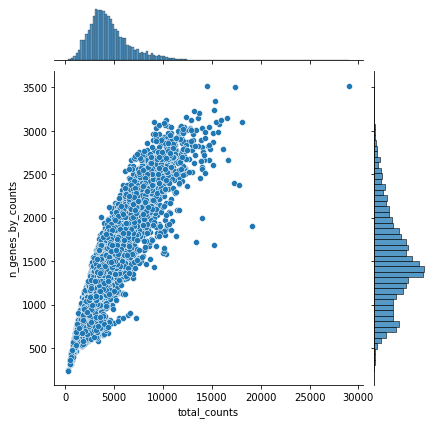

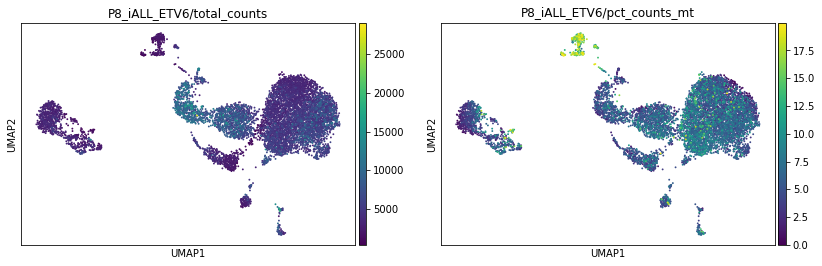

After filtering and preprocessing P8_iALL_ETV6 have  8474  cells


In [13]:
# Read SoupX processed data
adata_P8_iALL_ETV6 = sc.read_10x_mtx('data/single_cell_data/SoupX_processed_counts/ALL_AML_3/P8_iALL_ETV6_LK326_Dx_strained/', var_names='gene_symbols')
adata_P8_iALL_ETV6.raw = adata_P8_iALL_ETV6
adata_P8_iALL_ETV6.obs_names = adata_P8_iALL_ETV6.obs_names+'-P8_iALL_ETV6'

print('P8_iALL_ETV6 after SoupX have ', adata_P8_iALL_ETV6.shape[0], ' cells')
sc.pp.filter_cells(adata_P8_iALL_ETV6, min_genes=200)
adata_P8_iALL_ETV6.var['mt'] = adata_P8_iALL_ETV6.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata_P8_iALL_ETV6, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# filter cells with mito content >20%
adata_P8_iALL_ETV6 = adata_P8_iALL_ETV6[adata_P8_iALL_ETV6.obs.pct_counts_mt<20].copy()
sns.jointplot(data=adata_P8_iALL_ETV6.obs, x="total_counts", y="n_genes_by_counts")
sc.pp.normalize_per_cell(adata_P8_iALL_ETV6, counts_per_cell_after=1e4)
sc.pp.log1p(adata_P8_iALL_ETV6)
sc.pp.neighbors(adata_P8_iALL_ETV6)
sc.tl.umap(adata_P8_iALL_ETV6)
sc.pl.umap(adata_P8_iALL_ETV6, color = ['total_counts','pct_counts_mt'], title = ['P8_iALL_ETV6/total_counts','P8_iALL_ETV6/pct_counts_mt'])

print('After filtering and preprocessing P8_iALL_ETV6 have ', adata_P8_iALL_ETV6.shape[0], ' cells')
#adata_P8_iALL_ETV6.write_h5ad('data/single_cell_data/final_h5ad/P8_iALL_ETV6_Dx_RAW.h5ad')

<a id='cluster'></a>



# Merging data, UMAPs etc (Figure 2, panel B)

For each of single cell samples Laura Jardine have annotated cluster of cells as either cancerous or non-cancerous cells according to the expression of immunophenotype genes as mentioned in the the paper and Supp.Figures S1 and S2. I have clustered the data and assigned either /Cancer or /Normal in the column "patient_cancer" for each of the samples and saved h5ad object with the name extension _cancerInfo.h5ad for each sample in final_h5ad folder.

We can now read the h5ad object for each sample and merge them together so that we can show combined UMAP (like in Figure 2B).

Please unzip h5ad files first if you cloned github repository and reading files from here

In [15]:
import scanpy as sc
import pandas as pd


all_aml_files = ['data/single_cell_data/final_h5ad/P1_iALLM_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P2_iALLF_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P3_iALL_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P4_iALL_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P5_iALL_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P6_iALL_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P7_iALL_NUTM1_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P8_iALL_ETV6_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P9_iAML_Dx_cancerInfo.h5ad',
                 'data/single_cell_data/final_h5ad/P10_iAML_Dx_cancerInfo.h5ad']
sample_names = ['P1_iALLM', 'P2_iALL','P3_iALL',
                'P4_iALL', 'P5_iALL','P6_iALL',
                'P7_iALL_NUTM1','P8_iALL_ETV6','P9_iAML','P10_iAML']

adata_ALL_all = []
for i, filen in enumerate(all_aml_files):
    print(filen)
    adata_ALL_all.append(sc.read_h5ad(filen))

adata_ALL_new = adata_ALL_all[0].concatenate(adata_ALL_all[1:], batch_categories=sample_names)
adata_ALL_new.obs_names = pd.Series(adata_ALL_new.obs_names).str.rsplit('-', n=1, expand = True)[0].values
adata_ALL_new.obs.head()

/mnt/farmdir/Fetal_tissue_ness/resultsFinal/data/P1_iALLM_Dx_cancerInfo.h5ad
/mnt/farmdir/Fetal_tissue_ness/resultsFinal/data/P2_iALLF_Dx_cancerInfo.h5ad
/mnt/farmdir/Fetal_tissue_ness/resultsFinal/data/P3_iALL_Dx_cancerInfo.h5ad
/mnt/farmdir/Fetal_tissue_ness/resultsFinal/data/P4_iALL_Dx_cancerInfo.h5ad
/mnt/farmdir/Fetal_tissue_ness/resultsFinal/data/P5_iALL_Dx_cancerInfo.h5ad
/mnt/farmdir/Fetal_tissue_ness/resultsFinal/data/P6_iALL_Dx_cancerInfo.h5ad
/mnt/farmdir/Fetal_tissue_ness/resultsFinal/data/P7_iALL_NUTM1_Dx_cancerInfo.h5ad
/mnt/farmdir/Fetal_tissue_ness/resultsFinal/data/P8_iALL_ETV6_Dx_cancerInfo.h5ad
/mnt/farmdir/Fetal_tissue_ness/resultsFinal/data/P9_iAML_Dx_cancerInfo.h5ad
/mnt/farmdir/Fetal_tissue_ness/resultsFinal/data/P10_iAML_Dx_cancerInfo.h5ad


n_genes  n_genes_by_counts  total_counts  \
AAACGGGAGAAGGGTA-1/P1_iALLM     1286               1286        3829.0   
AAACGGGCAGCTCGCA-1/P1_iALLM      729                729        2805.0   
AAAGCAAGTAAGTAGT-1/P1_iALLM      633                633        1643.0   
AAAGCAATCAAGAAGT-1/P1_iALLM      993                993        2499.0   
AAAGTAGAGAGTACAT-1/P1_iALLM      934                934        2484.0   

                             total_counts_mt  pct_counts_mt  n_counts  \
AAACGGGAGAAGGGTA-1/P1_iALLM             91.0       2.376600    3829.0   
AAACGGGCAGCTCGCA-1/P1_iALLM             43.0       1.532977    2805.0   
AAAGCAAGTAAGTAGT-1/P1_iALLM             29.0       1.765064    1643.0   
AAAGCAATCAAGAAGT-1/P1_iALLM             29.0       1.160464    2499.0   
AAAGTAGAGAGTACAT-1/P1_iALLM             12.0       0.483092    2484.0   

                            souporcell     ygene     batch  patient_cancer  \
AAACGGGAGAAGGGTA-1/P1_iALLM          1  0.348242  P1_iALLM  P1_iALL/Cancer   
AAACGGGCAGCTCGCA-1/P1_iALLM          1  0.000000  P1_iALLM  P1_iALL/Normal   
AAAGCAAGTAAGTAGT-1/P1_iALLM          1  0.559480  P1_iALLM  P1_iALL/Cancer   
AAAGCAATCAAGAAGT-1/P1_iALLM          1  0.313940  P1_iALLM  P1_iALL/Cancer   
AAAGTAGAGAGTACAT-1/P1_iALLM          1  0.314705  P1_iALLM  P1_iALL/Cancer   

                            louvain  
AAACGGGAGAAGGGTA-1/P1_iALLM       3  
AAACGGGCAGCTCGCA-1/P1_iALLM       6  
AAAGCAAGTAAGTAGT-1/P1_iALLM       0  
AAAGCAATCAAGAAGT-1/P1_iALLM       4  
AAAGTAGAGAGTACAT-1/P1_iALLM       0

... storing 'souporcell' as categorical
... storing 'louvain' as categorical


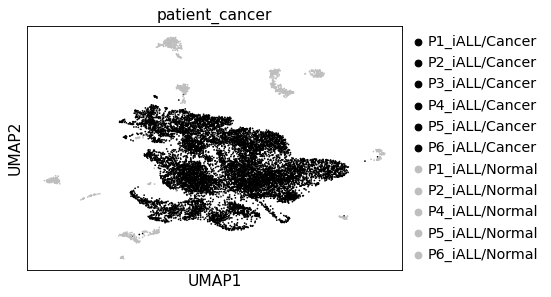

In [16]:
# some preprocessing to make sure that the text in figures are rendered properly
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# filter out to only include KMT2A-rearranged B-ALL (P1-6 iALL)
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('iALL')].copy()
adata_ALL_ALL = adata_ALL_ALL[~(adata_ALL_ALL.obs.patient_cancer.str.contains('ETV6')|
                             adata_ALL_ALL.obs.patient_cancer.str.contains('NUTM1'))].copy()

sc.pp.neighbors(adata_ALL_ALL)
sc.tl.umap(adata_ALL_ALL)

# Reorder category so that we have all "cancer" cells first and then "Normal"
adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains('Cancer')].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains('Normal')].values)))
currys
adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

sc.set_figure_params(figsize=[6,4], dpi_save=300)
adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][6:] = ['#BEBEBE']*5
f = sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer',show=False)

... storing 'louvain' as categorical


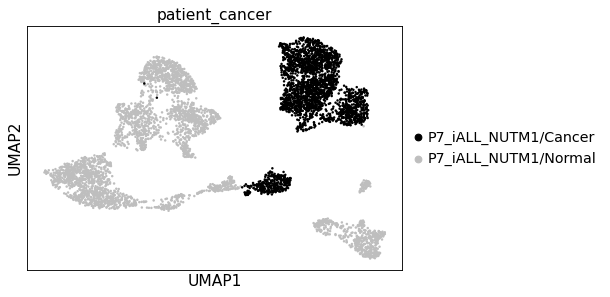

In [17]:
# Same for NUTM1
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('NUTM1')].copy()

sc.pp.neighbors(adata_ALL_ALL)
sc.tl.umap(adata_ALL_ALL)

adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
f = sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer',show=False)

... storing 'louvain' as categorical


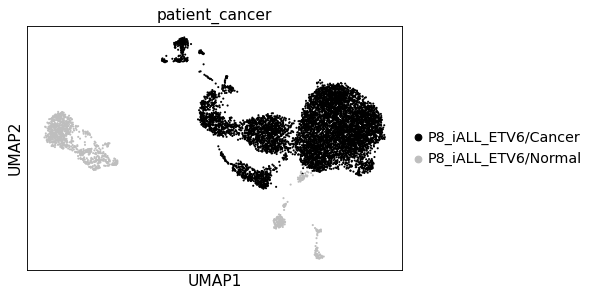

In [18]:
# Same for ETV6-RUNX1
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('ETV6')].copy()

sc.pp.neighbors(adata_ALL_ALL)
sc.tl.umap(adata_ALL_ALL)

adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
f = sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer',show=False)

... storing 'louvain' as categorical


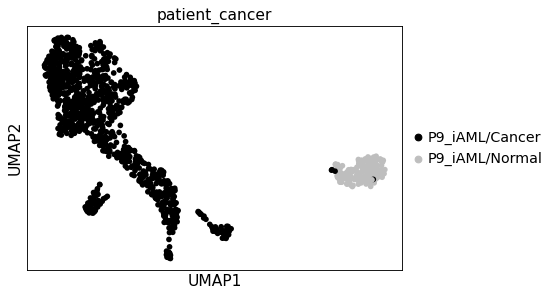

In [19]:
# Now AML: P9_iAML
adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('P9')].copy()

sc.pp.neighbors(adata_ALL_ALL)
sc.tl.umap(adata_ALL_ALL)

adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
f = sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer',show=False)

... storing 'souporcell' as categorical
... storing 'louvain' as categorical


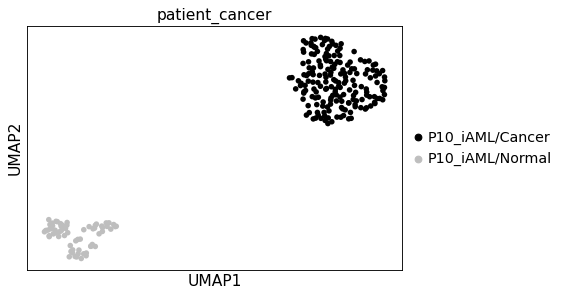

In [20]:
# another AML sample - megakaryocytic AML (P10_iAML)

adata_ALL_ALL = adata_ALL_new[adata_ALL_new.obs.patient_cancer.str.contains('P10')].copy()

sc.pp.neighbors(adata_ALL_ALL)
sc.tl.umap(adata_ALL_ALL)

adata_ALL_ALL.obs.patient_cancer = adata_ALL_ALL.obs.patient_cancer.astype('category')
base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer'])))].values))
obs_order.extend(list(np.unique(adata_ALL_ALL.obs['patient_cancer'][adata_ALL_ALL.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Normal'])))].values)))

adata_ALL_ALL.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_ALL_ALL.obs['patient_cancer'] = adata_ALL_ALL.obs['patient_cancer'].sort_values()

adata_ALL_ALL.uns['patient_cancer_colors'] = ['#000000']*adata_ALL_ALL.obs['patient_cancer'].nunique()
adata_ALL_ALL.uns['patient_cancer_colors'][1] = '#BEBEBE'
f = sc.pl.umap(adata_ALL_ALL, color = 'patient_cancer',show=False, size=100)

And last but not least: day 8 samples for P1_iALL and P2_iALL

... storing 'louvain' as categorical
... storing 'patient_cancer' as categorical


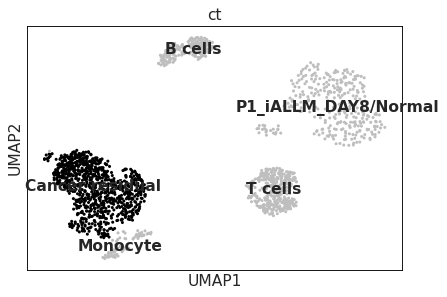

In [67]:
adata_P2_iALL_DAY8 = sc.read_h5ad('data/single_cell_data/final_h5ad/P2_iALLF_DAY8_combined_CANCERinfo.h5ad')
adata_P2_iALL_DAY8.obs['ct'] = 'Cancer residual'
adata_P2_iALL_DAY8.obs.loc[adata_P2_iALL_DAY8.obs.louvain.isin(['4', '5']), 'ct'] = 'T cells'
adata_P2_iALL_DAY8.obs.loc[adata_P2_iALL_DAY8.obs.louvain == '1', 'ct'] = 'B cells'
adata_P2_iALL_DAY8.obs.loc[adata_P2_iALL_DAY8.obs.louvain == '7', 'ct'] = 'Monocyte'

adata_P1_iALL_DAY8 = sc.read_h5ad('data/single_cell_data/final_h5ad/P1_iALLM_DAY8_combined_CANCERinfo.h5ad')
adata_P1_iALL_DAY8.obs['ct'] = adata_P1_iALL_DAY8.obs.patient_cancer
adata_P2_iALL_DAY8 = adata_P2_iALL_DAY8.concatenate(adata_P1_iALL_DAY8)
adata_P2_iALL_DAY8.obs['ct'] = adata_P2_iALL_DAY8.obs['ct'].astype('category')
adata_P2_iALL_DAY8.obs['ct'].cat.reorder_categories(['Cancer residual','B cells', 'Monocyte', 'T cells', 'P1_iALLM_DAY8/Normal'], inplace=True)
adata_P2_iALL_DAY8.obs['ct'] = adata_P2_iALL_DAY8.obs['ct'].sort_values()

adata_P2_iALL_DAY8.uns['ct_colors'] = ['#000000']*adata_P2_iALL_DAY8.obs['ct'].nunique()
adata_P2_iALL_DAY8.uns['ct_colors'][1:] = ['#BEBEBE']*4

sc.set_figure_params(figsize=[6,4], dpi_save=300)
sc.pl.umap(adata_P2_iALL_DAY8, color ='ct', size = 30, legend_loc = 'on data')

<a id='logreg'></a>


# Logistic regression

Results of logistic regression analysis, i.e. single cell cancer to normal comparison. Scores represent the probability that particular leukemia single cell is transciptomically similar to all the cells belonging to the particular normal reference cell type. Max probability = 1 (very similar), min probability = 0 (very DISsimilar) and 0.5 represents somewhat random similarity.

/home/ubuntu/.local/lib/python3.6/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  _ = ax.pcolor(_color_df, **kwds)


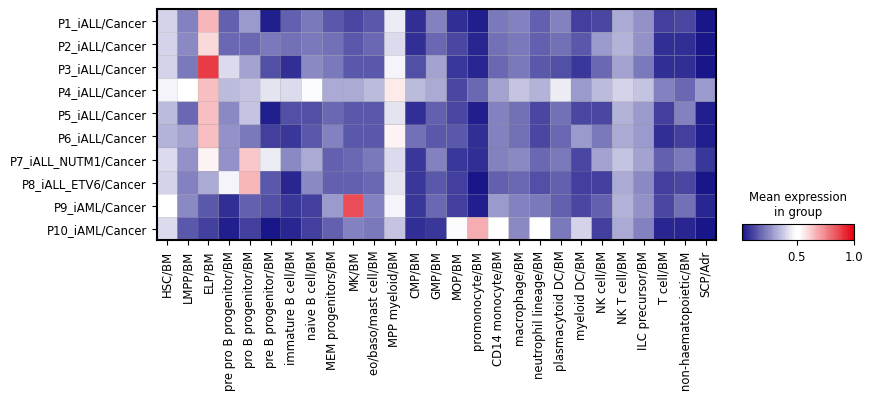

In [125]:
# Figure 2, panel A
import pandas as pd
import numpy as np
import scanpy as sc
from matplotlib.colors import LinearSegmentedColormap

tmpf = pd.read_csv('analysis_results/logreg/InfALL_allSAMPLES_LogregFBM.csv', header=0, index_col=0)
adata_new = sc.AnnData(tmpf)
adata_new.X[np.isnan(adata_new.X)] = -1

adata_new.obs['patient_cancer'] = adata_ALL_new.obs.loc[tmpf.index].patient_cancer
adata_new = adata_new[~adata_new.obs.patient_cancer.str.contains('Normal')].copy()

adata_new.var_names = adata_new.var_names+'/BM'
vn = pd.Series(adata_new.var_names)
vn[vn == 'SCP/BM'] = 'SCP/Adr'
adata_new.var_names = vn.values

base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer', 'ALL'])))].values))
obs_order.extend(list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer', 'P9_iAML'])))].values)))
obs_order.extend(list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer', 'P10_iAML'])))].values)))

adata_new.obs['patient_cancer'] = adata_new.obs['patient_cancer'].astype('category')
adata_new.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_new.obs['patient_cancer'] = adata_new.obs['patient_cancer'].sort_values()
adata_new = adata_new[~adata_new.obs.patient_cancer.str.contains('low')]
adata_new = adata_new[~adata_new.obs.patient_cancer.str.contains('myel')]

cm = LinearSegmentedColormap.from_list('mycmap', [(0, '#191689'),(0.48, '#FFFFFF'), (0.52, '#FFFFFF'), (1, '#E30613')], N=60)
tmp = ['HSC/BM', 'LMPP/BM', 'ELP/BM','pre pro B progenitor/BM', 'pro B progenitor/BM', 'pre B progenitor/BM', 'immature B cell/BM', 'naive B cell/BM',
      'MEM progenitors/BM', 'MK/BM', 'eo/baso/mast cell/BM', 'MPP myeloid/BM', 'CMP/BM', 'GMP/BM', 'MOP/BM', 'promonocyte/BM', 'CD14 monocyte/BM',
      'macrophage/BM','neutrophil lineage/BM', 'plasmacytoid DC/BM', 'myeloid DC/BM', 'NK cell/BM', 'NK T cell/BM', 'ILC precursor/BM',
      'T cell/BM', 'non-haematopoietic/BM', 'SCP/Adr']

sc.pl.matrixplot(adata_new, tmp, groupby='patient_cancer', figsize=[9,3], vmax =1,cmap = cm)



Trying to set attribute `.obs` of view, copying.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


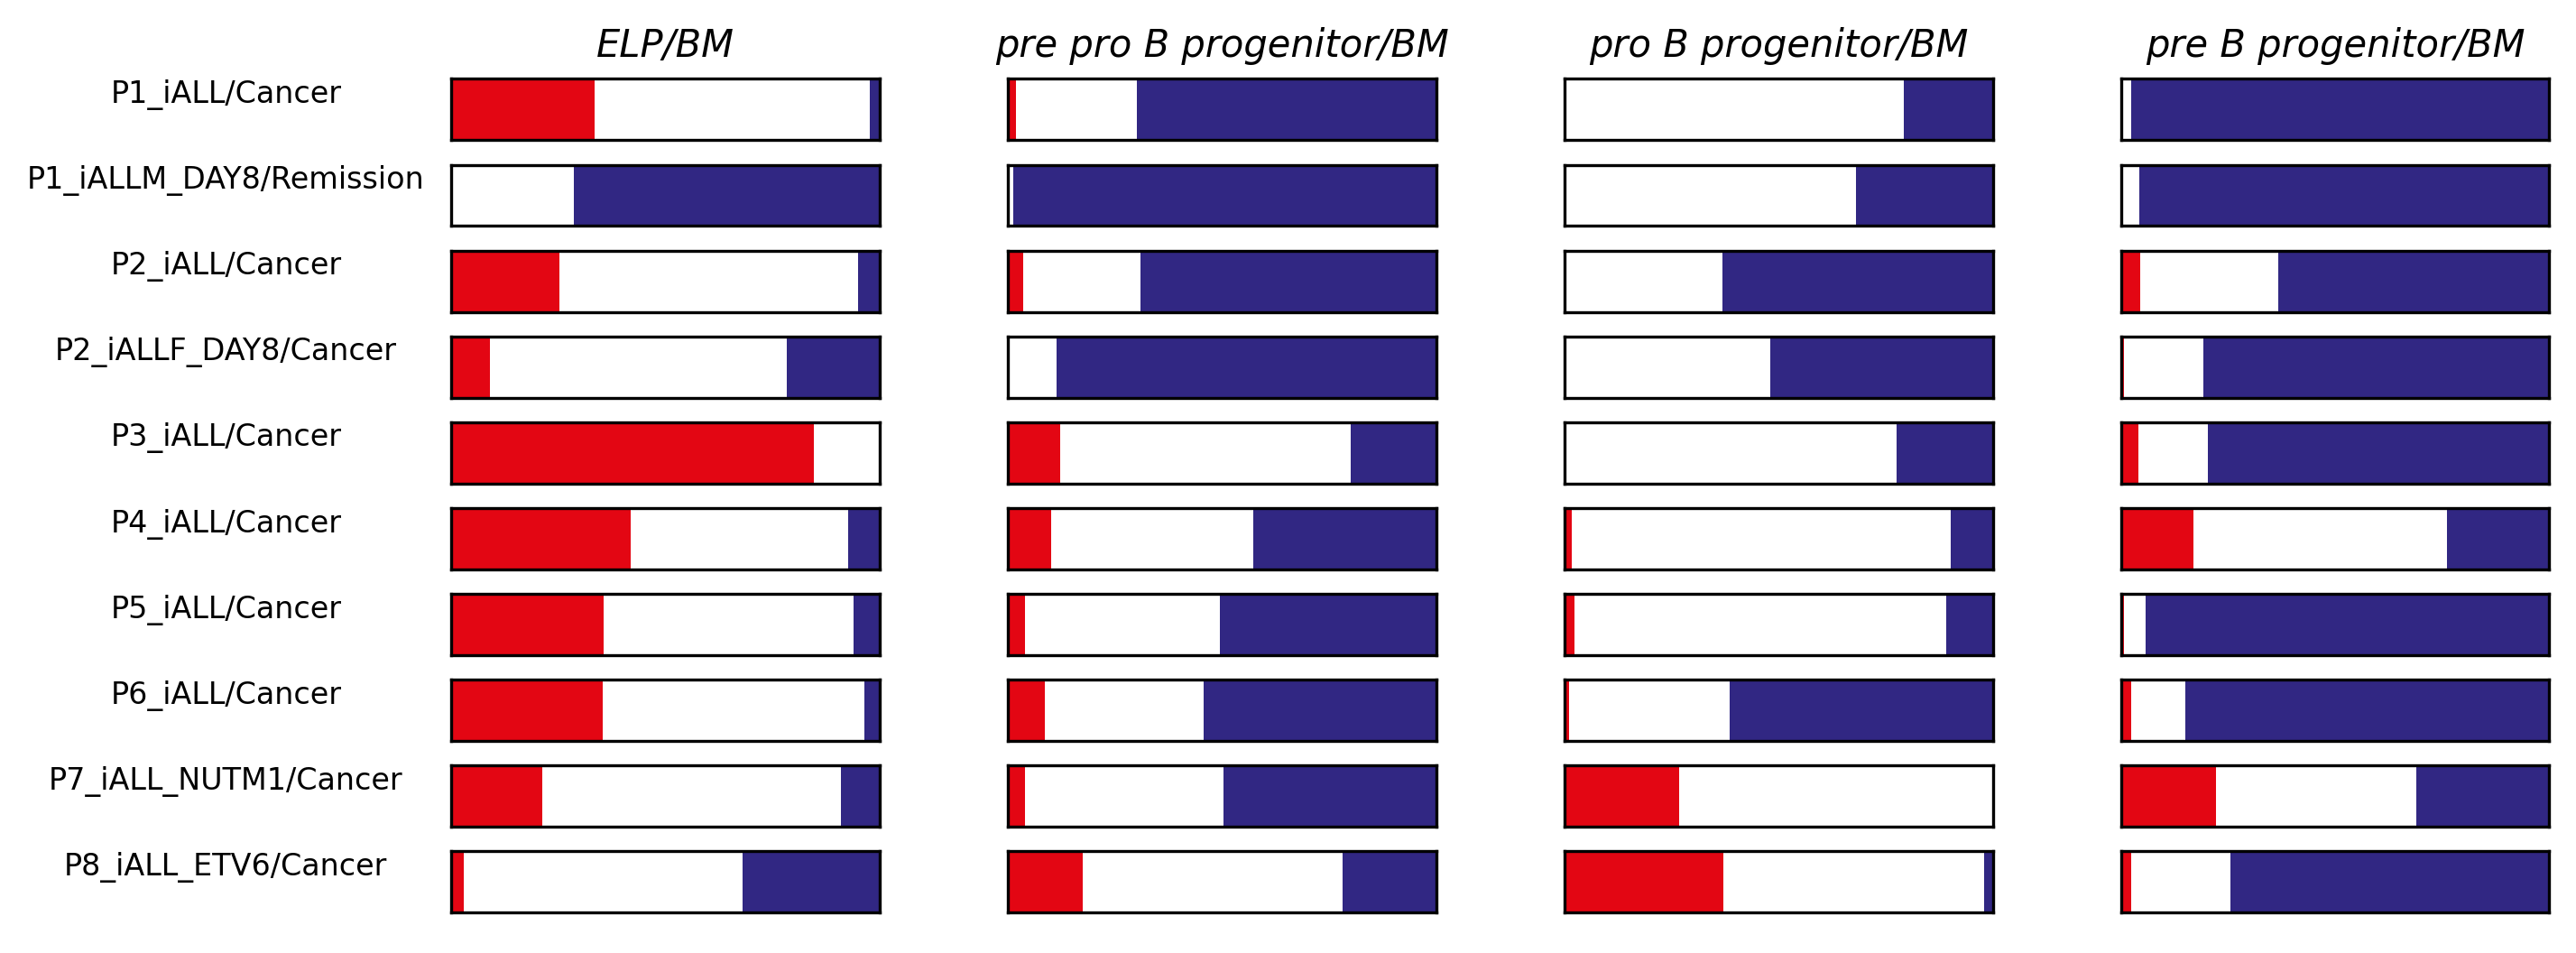

In [126]:
#Figure 2, panel C
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
base = r'^{}'
expr = '(?=.*{})'

tmpf = pd.read_csv('analysis_results/logreg/InfALL_allSAMPLES_LogregFBM.csv', header=0, index_col=0)
df_p1_day8 = pd.read_csv('analysis_results/logreg/P1_iALL_DAY8.csv', index_col = 0)
df_p1_day8.index = df_p1_day8.index+'/P1_iALLM_DAY8'
df_p2_day8 = pd.read_csv('analysis_results/logreg/P2_iALL_DAY8.csv', index_col = 0)
df_p2_day8.index = df_p2_day8.index+'/P2_iALLM_DAY8'
adata_p1_day8 = sc.AnnData(df_p1_day8)
adata_p1_day8 = adata_p1_day8[:,~np.isnan(adata_p1_day8.X).all(0)]
adata_p1_day8.obs['patient_cancer'] = 'P1_iALLM_DAY8/Remission'
adata_p2_day8 = sc.AnnData(df_p2_day8)
adata_P2_iALL_DAY8 = sc.read_h5ad('data/single_cell_data/final_h5ad/P2_iALLF_DAY8_combined_CANCERinfo.h5ad')
adata_P2_iALL_DAY8.obs['ct'] = 'Cancer residual'
adata_P2_iALL_DAY8.obs.loc[adata_P2_iALL_DAY8.obs.louvain.isin(['4', '5']), 'ct'] = 'T cells'
adata_P2_iALL_DAY8.obs.loc[adata_P2_iALL_DAY8.obs.louvain == '1', 'ct'] = 'B cells'
adata_P2_iALL_DAY8.obs.loc[adata_P2_iALL_DAY8.obs.louvain == '7', 'ct'] = 'Monocyte'
adata_p2_day8.obs['patient_cancer'] = adata_P2_iALL_DAY8.obs.loc[pd.Series(adata_p2_day8.obs.index).str.rsplit('/', n=1, expand = True)[0].values].patient_cancer.values
adata_p2_day8 = adata_p2_day8[:,~np.isnan(adata_p2_day8.X).all(0)]
adata_p1_day8.var_names = vn.values
adata_p2_day8.var_names = vn.values

adata_new = adata_new.concatenate(adata_p1_day8,adata_p2_day8)
adata_new = adata_new[~(adata_new.obs.patient_cancer.str.contains('Normal') | adata_new.obs.patient_cancer.str.contains('AML'))].copy()

base = r'^{}'
expr = '(?=.*{})'
obs_order = list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['ALL'])))].values))
obs_order.extend(list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer', 'P9_iAML'])))].values)))
obs_order.extend(list(np.unique(adata_new.obs['patient_cancer'][adata_new.obs['patient_cancer'].str.contains(base.format(''.join(expr.format(w) for w in ['Cancer', 'P10_iAML'])))].values)))

adata_new.obs['patient_cancer'] = adata_new.obs['patient_cancer'].astype('category')
adata_new.obs['patient_cancer'].cat.reorder_categories(obs_order, inplace=True)
adata_new.obs['patient_cancer'] = adata_new.obs['patient_cancer'].sort_values()

Bcelllin= ['ELP/BM','pre pro B progenitor/BM', 'pro B progenitor/BM', 'pre B progenitor/BM',]
height_ratios = [1]*adata_new.obs.patient_cancer.nunique()
thresh_low = 0.2
thresh_high = 0.8
df_similarity = {}

fig = plt.figure(figsize = (10,4), dpi=300)
spec = fig.add_gridspec(ncols=len(Bcelllin), nrows=adata_new.obs.patient_cancer.nunique(),hspace = 0.4,wspace = 0.3, height_ratios=height_ratios)
for i, p in enumerate(adata_new.obs.patient_cancer.cat.categories):

    adata_tmp = adata_new[adata_new.obs.patient_cancer == p].copy()
    for j, ct in enumerate(Bcelllin):
        ax = fig.add_subplot(spec[i,j],aspect='auto')
        adata_tmp2 = adata_tmp[:, ct].copy()
        df_tmp = pd.DataFrame({'ELP_sim':(adata_tmp2[adata_tmp2[:, ct].X.max(1)>=thresh_high].shape[0])/adata_tmp2.shape[0]*100,
                               'other_ct': (adata_tmp2[(adata_tmp2[:, ct].X.max(1)>thresh_low) & (adata_tmp2[:, ct].X.max(1)<thresh_high)].shape[0])/adata_tmp2.shape[0]*100,
                              'ELP_dissim':(adata_tmp2[adata_tmp2[:, ct].X.max(1)<=thresh_low].shape[0])/adata_tmp2.shape[0]*100}, index = [ct])
        df_tmp.plot.barh(stacked=True, ax = ax, color = ['#E30613', 'white', '#312783'])
        ax.set_xlabel('')

        if i==0:
            ax.set_title(ct,fontsize = 10, style='oblique')
        ax.tick_params(axis="x", rotation=90,labelsize = 8)
        ax.get_legend().remove()
        ax.set_ylim([-0.05,0.05])
        if j==0:
            ax.set_ylabel(p, rotation = 0, labelpad=60, fontsize = 8)
        ax.set_yticks([])
        ax.set_yticklabels([])        
        ax.set_xticks([])
        ax.set_xlim([0, df_tmp.sum(1).values[0]-1])
        ax.set_xticklabels([])
        if ct == 'ELP/BM':
            df_similarity[p] = (df_tmp/df_tmp.sum(1).values[0]).loc['ELP/BM','ELP_sim']
    plt.tight_layout()



<a id='deconv'></a>

# Bulk RNA-seq deconvolution

Deconvolution analysis of bulk RNA-seq leukemia samples from St.Jude and TARGET cohorts.

/home/ubuntu/.local/lib/python3.6/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  _ = ax.pcolor(_color_df, **kwds)


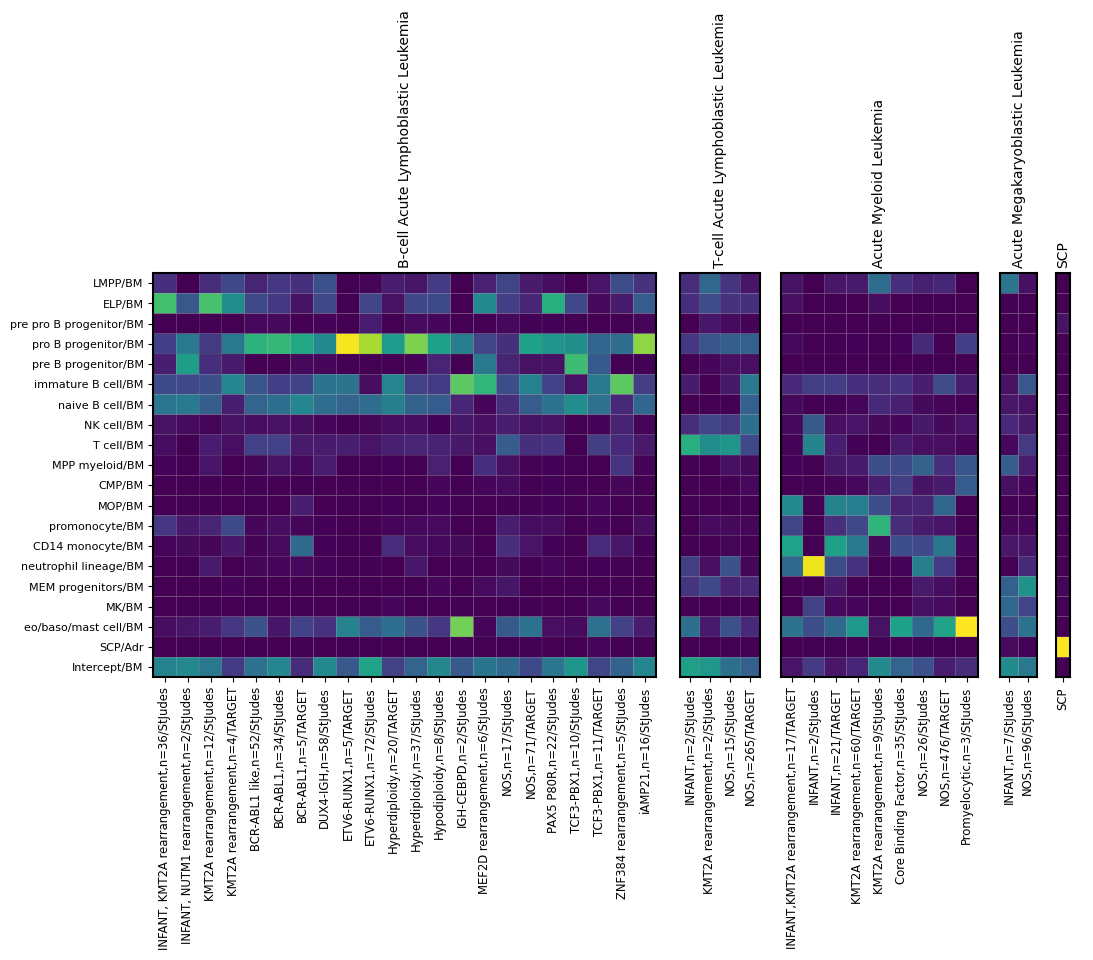

In [127]:
import pandas as pd
import scanpy as sc

# rewritten function from R to Python 
# original function written in R is in cellSignalAnalysis.R script 
# in https://github.com/constantAmateur/cellSignalAnalysis
# Load's the exposure table, separates out the goodness-of-fit metrics and exposures and normalises the exposures to sum to 1 across each sample.
def normaliseExposures(tgt):
    #Is this just the base?
    fit = pd.read_csv(tgt,sep='\t')
    fit = fit[sorted(fit.columns)]
    #Extract the goodness of fit rows
    gofNoms = ['pR2','fitCount','obsCount']
    gof = fit.loc[gofNoms]
    gof.loc['log2(countRatio)'] = np.log2(gof.loc['fitCount']/gof.loc['obsCount'])
    exposures = fit.loc[~fit.index.isin(gofNoms)]
    exposures = exposures/exposures.sum(0)
    #Done
    return {'exposures': exposures, 'gof': gof,'raw':fit.loc[~fit.index.isin(gofNoms)]}


celltype_2plot = ['LMPP/BM', 'ELP/BM','pre pro B progenitor/BM', 'pro B progenitor/BM', 'pre B progenitor/BM', 'immature B cell/BM', 'naive B cell/BM',
      'NK cell/BM','T cell/BM','MPP myeloid/BM','CMP/BM', 'MOP/BM','promonocyte/BM', 'CD14 monocyte/BM',
      'neutrophil lineage/BM', 'MEM progenitors/BM', 'MK/BM', 'eo/baso/mast cell/BM',    
      'SCP/Adr', 'Intercept/BM']


stjudes_path = 'analysis_results/deconvolution/StJudes_deconvFetalBM_Broad400wSCP_fitExposures.tsv'
target_path = 'analysis_results/deconvolution/TARGET_deconvFetalBM_Broad400wSCP_fitExposures.tsv'

stjudes_meta = pd.read_csv('data/bulk_data/StJude/StJude_Metadata_final_filtered.csv', sep = ',', index_col=0)
fit = normaliseExposures(stjudes_path)
fit = fit['exposures']
fit.columns = pd.Series(fit.columns).str.split('.', expand = True, n=1)[0].values
adata_stjudes = sc.AnnData(fit.T)
adata_stjudes = adata_stjudes[adata_stjudes.obs_names.isin(stjudes_meta.index)]
adata_stjudes.obs = stjudes_meta

target_meta = pd.read_csv('data/bulk_data/TARGET/TARGET_Metadata_final_filtered.csv', index_col=0)
fit = normaliseExposures(target_path)
fit = fit['exposures']
fit.columns = pd.Series(fit.columns).str.split('.', expand = True, n=1)[0].values
adata_target = sc.AnnData(fit.T)
adata_target = adata_target[adata_target.obs_names.isin(target_meta.index.values)]
adata_target.obs = target_meta

fit = normaliseExposures('analysis_results/deconvolution/SCP_deconvFetalBM_Broad400wSCP_fitExposures.tsv')
fit = fit['exposures']#.iloc[:-1]
adata_scp = sc.AnnData(fit.T)
adata_scp.obs['disease'] = adata_scp.obs_names
adata_scp.obs['disease_new'] = 'SCP'
adata_scp.obs['disease_type'] = 'SCP'
adata_scp.obs['disease_subtype'] = 'SCP'



adata_leukcomb = adata_stjudes.concatenate(adata_target, adata_scp, batch_categories = ['StJudes', 'TARGET', 'SCP'])
adata_leukcomb = adata_leukcomb[~adata_leukcomb.obs.disease_subtype.str.contains('n=1/')]
adata_leukcomb.var_names = adata_leukcomb.var_names + '/BM'
vn = pd.Series(adata_leukcomb.var_names)
vn[vn == 'SCP/BM'] = 'SCP/Adr'
adata_leukcomb.var_names = vn.values

fig = plt.figure(constrained_layout=False, figsize = (12,6))

disorder = ['B-cell Acute Lymphoblastic Leukemia',
            'T-cell Acute Lymphoblastic Leukemia',
            'Acute Myeloid Leukemia',     
            'Acute Megakaryoblastic Leukemia',
            'SCP']


height_ratios = adata_leukcomb.obs.groupby('disease_type').disease_subtype.nunique().loc[disorder].sum()
height_ratios = np.ceil((adata_leukcomb.obs.groupby('disease_type').disease_subtype.nunique().loc[disorder]/height_ratios*100))

spec = fig.add_gridspec(nrows=1, ncols=len(disorder),wspace = 0.01, width_ratios=height_ratios)

for i,d in enumerate(disorder):
    ax2 = fig.add_subplot(spec[i],aspect='auto')
    adata_tmp = adata_leukcomb[adata_leukcomb.obs.disease_type == d].copy()
    adata_tmp.obs.disease_subtype = adata_tmp.obs.disease_subtype.astype('category')
    adata_tmp.obs = adata_tmp.obs.astype('category')
    ll = list(adata_tmp.obs.disease_subtype.cat.categories)
    ll2 = [x for x in ll if 'INFANT' in x]
    ll2.extend([x for x in ll if 'KMT2A' in x and 'INFANT' not in x])
    ll2.extend(np.setdiff1d(ll, ll2))
    adata_tmp.obs.disease_subtype = adata_tmp.obs.disease_subtype.cat.reorder_categories(ll2)  
    f = sc.pl.MatrixPlot(adata_tmp, celltype_2plot, groupby='disease_subtype', cmap='viridis', ax=ax2,vmax = 0.4).swap_axes().legend(width =0).get_axes()
    f['mainplot_ax'].tick_params(axis="y", labelsize=8)#, rotation = 180)
    f['mainplot_ax'].set_title(d, fontsize = 10, rotation = 90)
    if i>0:
        f['mainplot_ax'].set_yticks([])

In [128]:
BALL_map = {'INFANT_B-cell Acute Lymphoblastic Leukemia, KMT2A rearrangement,n=36/StJudes': 'MLL',
              'B-cell Acute Lymphoblastic Leukemia, KMT2A rearrangement,n=12/StJudes': 'MLL',
              'B-cell Acute Lymphoblastic Leukemia, KMT2A rearrangement,n=4/TARGET': 'MLL',
             'INFANT_B-cell Acute Lymphoblastic Leukemia, NUTM1 rearrangement,n=2/StJudes': 'NUTM1',
             'B-cell Acute Lymphoblastic Leukemia, ETV6-RUNX1,n=72/StJudes': 'Low risk',
             'B-cell Acute Lymphoblastic Leukemia, ETV6-RUNX1,n=5/TARGET': 'Low risk',       
             'B-cell Acute Lymphoblastic Leukemia, Hyperdiploidy,n=37/StJudes': 'Low risk',
             'B-cell Acute Lymphoblastic Leukemia, Hyperdiploidy,n=20/TARGET': 'Low risk',
             'B-cell Acute Lymphoblastic Leukemia, TCF3-PBX1,n=10/StJudes': 'Low risk',
             'B-cell Acute Lymphoblastic Leukemia, TCF3-PBX1,n=11/TARGET': 'Low risk',
             'B-cell Acute Lymphoblastic Leukemia, iAMP21,n=16/StJudes': 'High risk',
             'B-cell Acute Lymphoblastic Leukemia, Hypodiploidy,n=8/StJudes': 'High risk',
             'B-cell Acute Lymphoblastic Leukemia, BCR-ABL1 like,n=52/StJudes': 'High risk',
             'B-cell Acute Lymphoblastic Leukemia, BCR-ABL1,n=34/StJudes': 'High risk',
             'B-cell Acute Lymphoblastic Leukemia, BCR-ABL1,n=5/TARGET': 'High risk', 
             'B-cell Acute Lymphoblastic Leukemia, DUX4-IGH,n=58/StJudes': 'Other',
             'B-cell Acute Lymphoblastic Leukemia, PAX5 P80R,n=22/StJudes': 'Other',
             'B-cell Acute Lymphoblastic Leukemia, IGH-CEBPD,n=2/StJudes': 'Other',
             'B-cell Acute Lymphoblastic Leukemia, MEF2D rearrangement,n=6/StJudes': 'Other',
             'B-cell Acute Lymphoblastic Leukemia, ZNF384 rearrangement,n=5/StJudes': 'Other',
            'B-cell Acute Lymphoblastic Leukemia, NOS,n=17/StJudes': 'Other',
            'B-cell Acute Lymphoblastic Leukemia, NOS,n=71/TARGET': 'Other',
            'INFANT_Acute Leukemias of Ambiguous Lineage, KMT2A rearrangement,n=7/TARGET': 'ALAL, KMT2A',
            'Acute Leukemias of Ambiguous Lineage, KMT2A rearrangement,n=2/TARGET': 'ALAL, KMT2A'
           }


Trying to set attribute `.obs` of view, copying.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

SCP (5, 4)
AML, KMT2A (86, 4)
ALAL, KMT2A (9, 4)
MLL (52, 4)
NUTM1 (2, 4)
Low risk (155, 4)
High risk (115, 4)
Other (181, 4)


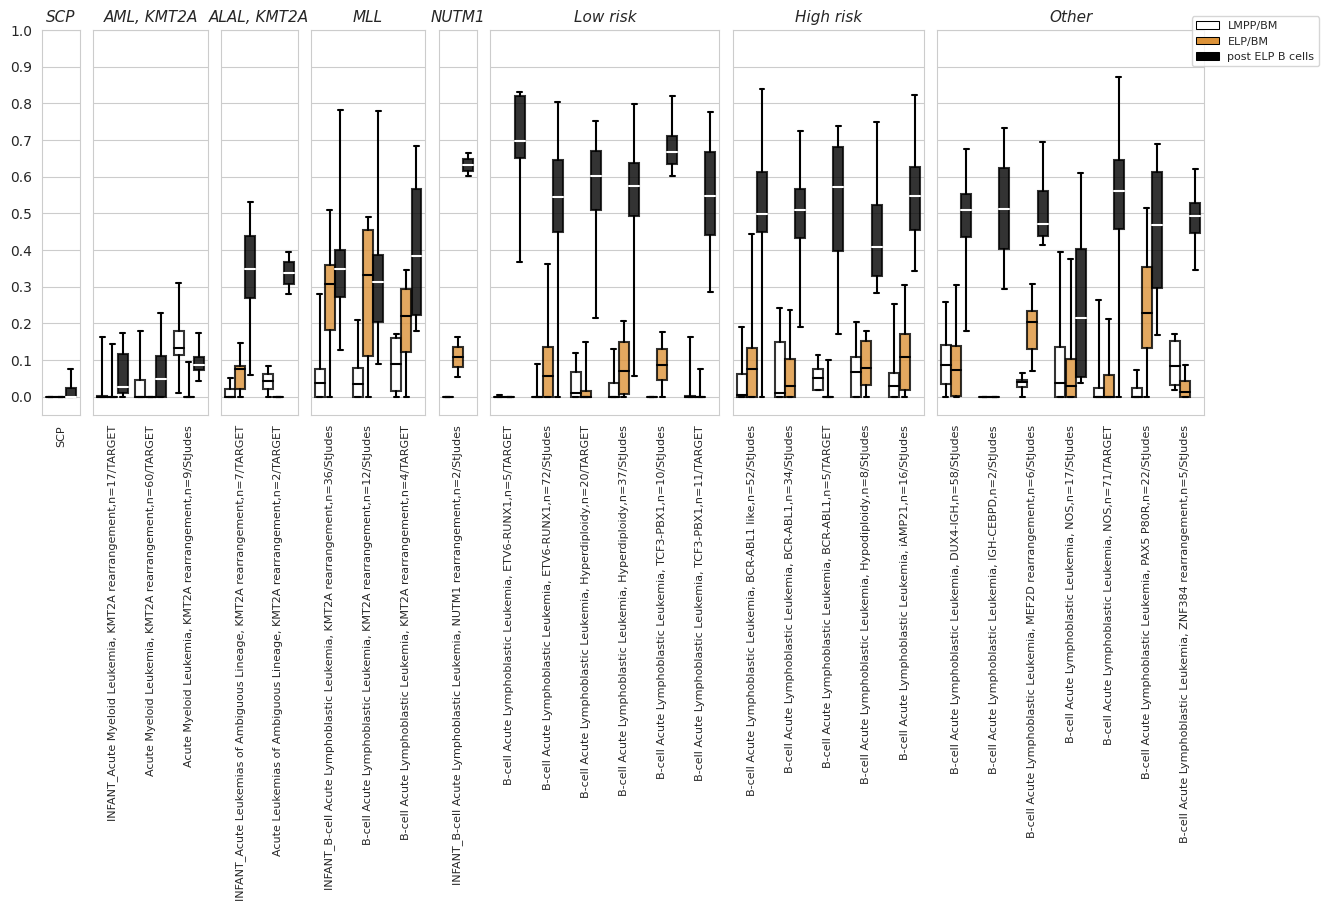

In [129]:
# Figure 1C, top

sns.set_style("whitegrid")

plotcolor= ['white',"#F7941D",  'black']
Bcelllin= ['pre B progenitor/BM','pre pro B progenitor/BM', 'pro B progenitor/BM', 'naive B cell/BM', 'immature B cell/BM']

adata_leukcomb.obs['disease_batch'] = adata_leukcomb.obs.disease_new.astype(str)+'/'+adata_leukcomb.obs.batch.astype(str)

adata_leukcomb_sub = adata_leukcomb[adata_leukcomb.obs.disease_type.isin(['Acute Myeloid Leukemia', 'B-cell Acute Lymphoblastic Leukemia','SCP','Acute Leukemias of Ambiguous Lineage'])].copy()
adata_leukcomb_sub = adata_leukcomb_sub[np.setdiff1d(adata_leukcomb_sub.obs_names,adata_leukcomb_sub[(adata_leukcomb_sub.obs.disease_type == 'Acute Myeloid Leukemia') & (~adata_leukcomb_sub.obs.disease_subtype.str.contains('KMT2A'))].obs_names)]
adata_leukcomb_sub = adata_leukcomb_sub[np.setdiff1d(adata_leukcomb_sub.obs_names,adata_leukcomb_sub[(adata_leukcomb_sub.obs.disease_type == 'Acute Leukemias of Ambiguous Lineage') & (~adata_leukcomb_sub.obs.disease_subtype.str.contains('KMT2A'))].obs_names)]

adata_leukcomb_sub.obs['B_ALL_groups'] = adata_leukcomb_sub.obs.disease_batch.map(BALL_map)
adata_leukcomb_sub.obs['B_ALL_groups'][adata_leukcomb_sub.obs.disease_batch.str.contains('SCP')] = 'SCP'
adata_leukcomb_sub.obs['disease_batch'][adata_leukcomb_sub.obs.disease_batch.str.contains('SCP')] = 'SCP'

adata_leukcomb_sub.obs['B_ALL_groups'][adata_leukcomb_sub.obs.disease_batch.str.contains('Myeloid')] = 'AML, KMT2A'

tmp = pd.DataFrame(adata_leukcomb_sub.X, index = adata_leukcomb_sub.obs_names, columns = adata_leukcomb_sub.var_names)
tmp['cancer'] = adata_leukcomb_sub.obs.disease_batch.astype(str).values
tmp['cancer_groups'] = adata_leukcomb_sub.obs.B_ALL_groups.astype(str).values

groups_order = ['SCP', 'AML, KMT2A', 'ALAL, KMT2A', 'MLL','NUTM1','Low risk', 'High risk', 'Other']

widths = list(adata_leukcomb_sub.obs.groupby('B_ALL_groups')['disease_subtype'].nunique().loc[groups_order])
fig = plt.figure(constrained_layout=False, figsize = (15,5))
spec = fig.add_gridspec(ncols=adata_leukcomb_sub.obs.B_ALL_groups.nunique(), nrows=1, width_ratios=widths, wspace = 0.1, hspace = 0.4)
all_stats = []

for i, p in enumerate(groups_order):
    ax = fig.add_subplot(spec[0,i])
    ax.set_yticks(np.linspace(0,1,11))
    tmp_dis1 = tmp[tmp['cancer_groups'] == p].copy()
    tmp_dis1['post ELP B cells'] = tmp_dis1[Bcelllin].sum(1)
    tmp_dis1 = tmp_dis1[['LMPP/BM', 'ELP/BM', 'post ELP B cells', 'cancer']]
    tmp_dis1.cancer = tmp_dis1.cancer.astype('category')
    ll = list(tmp_dis1.cancer.cat.categories)
    ll2 = [x for x in ll if 'INFANT' in x and 'KMT2A' in x]
    ll2.extend([x for x in ll if 'KMT2A' in x and 'INFANT' not in x])
    ll2.extend([x for x in ll if 'INFANT' in x and 'KMT2A' not in x])
    ll2.extend(np.setdiff1d(ll, ll2))
    tmp_dis1.cancer = tmp_dis1.cancer.cat.reorder_categories(ll2)  
    tmp_dis1.sort_values('cancer', inplace=True)
    print(p, tmp_dis1.shape)
    tmp_dis1 = tmp_dis1.melt(id_vars='cancer')
    g = sns.boxplot(x="cancer", y="value", data=tmp_dis1, hue = 'variable',ax=ax,
        boxprops=dict(alpha=.8),fliersize=0,palette=plotcolor, 
        whis=[0, 100])
    ax.set_title(label=p,fontsize = 11, style='oblique')

    if i>0:
        ax.set_yticklabels([])
    if i<len(groups_order)-1:
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1.45, 1.05), fontsize = 8)
    ax.set_xlabel('')
    ax.set_ylabel("")
    ax.set_ylim([-0.05,1])
    ax.tick_params(axis="x", rotation=90,labelsize = 8)
    
    for line in ax.get_lines()[16::18]:
        line.set_color('white')


Trying to set attribute `.obs` of view, copying.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SCP (5, 2)
AML, KMT2A (86, 2)
ALAL, KMT2A (9, 2)
MLL (52, 2)
NUTM1 (2, 2)
Low risk (155, 2)
High risk (115, 2)
Other (181, 2)


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


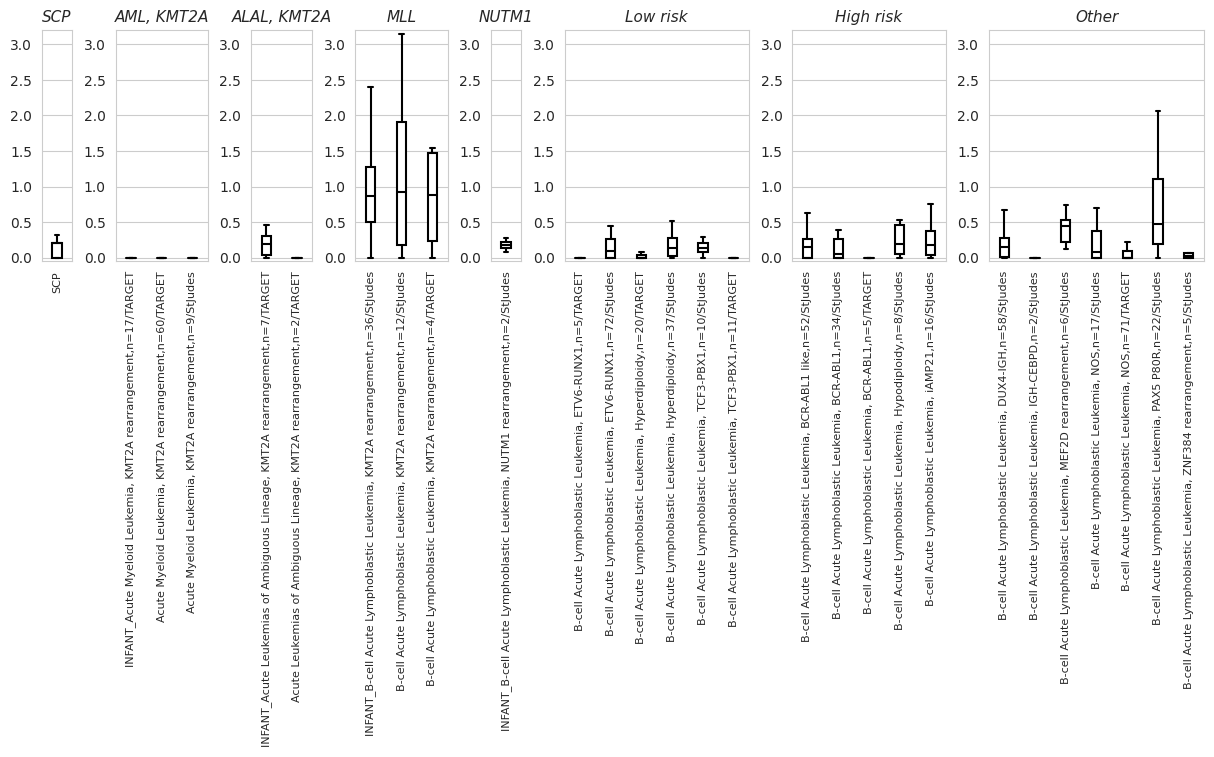

In [131]:
# Figure 1C, bottom

plotcolor= ['white',"#F7941D",  'black']
Bcelllin= ['pre B progenitor/BM','pre pro B progenitor/BM', 'pro B progenitor/BM', 'naive B cell/BM', 'immature B cell/BM']

adata_leukcomb.obs['disease_batch'] = adata_leukcomb.obs.disease_new.astype(str)+'/'+adata_leukcomb.obs.batch.astype(str)
adata_leukcomb_sub = adata_leukcomb[adata_leukcomb.obs.disease_type.isin(['Acute Myeloid Leukemia', 'B-cell Acute Lymphoblastic Leukemia','SCP','Acute Leukemias of Ambiguous Lineage'])].copy()
adata_leukcomb_sub = adata_leukcomb_sub[np.setdiff1d(adata_leukcomb_sub.obs_names,adata_leukcomb_sub[(adata_leukcomb_sub.obs.disease_type == 'Acute Myeloid Leukemia') & (~adata_leukcomb_sub.obs.disease_subtype.str.contains('KMT2A'))].obs_names)]
adata_leukcomb_sub = adata_leukcomb_sub[np.setdiff1d(adata_leukcomb_sub.obs_names,adata_leukcomb_sub[(adata_leukcomb_sub.obs.disease_type == 'Acute Leukemias of Ambiguous Lineage') & (~adata_leukcomb_sub.obs.disease_subtype.str.contains('KMT2A'))].obs_names)]

adata_leukcomb_sub.obs['B_ALL_groups'] = adata_leukcomb_sub.obs.disease_batch.map(BALL_map)
adata_leukcomb_sub.obs['B_ALL_groups'][adata_leukcomb_sub.obs.disease_batch.str.contains('SCP')] = 'SCP'
adata_leukcomb_sub.obs['disease_batch'][adata_leukcomb_sub.obs.disease_batch.str.contains('SCP')] = 'SCP'

adata_leukcomb_sub.obs['B_ALL_groups'][adata_leukcomb_sub.obs.disease_batch.str.contains('Myeloid')] = 'AML, KMT2A'

tmp = pd.DataFrame(adata_leukcomb_sub.X, index = adata_leukcomb_sub.obs_names, columns = adata_leukcomb_sub.var_names)
tmp['cancer'] = adata_leukcomb_sub.obs.disease_batch.astype(str).values
tmp['cancer_groups'] = adata_leukcomb_sub.obs.B_ALL_groups.astype(str).values

groups_order = ['SCP', 'AML, KMT2A', 'ALAL, KMT2A', 'MLL','NUTM1','Low risk', 'High risk', 'Other']

widths = list(adata_leukcomb_sub.obs.groupby('B_ALL_groups')['disease_subtype'].nunique().loc[groups_order])
fig = plt.figure(constrained_layout=False, figsize = (15,3))
spec = fig.add_gridspec(ncols=adata_leukcomb_sub.obs.B_ALL_groups.nunique(), nrows=1, width_ratios=widths, wspace = 0.4, hspace = 0.4)
all_stats = []

for i, p in enumerate(groups_order):
    ax = fig.add_subplot(spec[0,i])
    df_ratios = tmp[tmp['cancer_groups'] == p].copy()
    df_ratios['post ELP B cells'] = df_ratios[Bcelllin].sum(1)
    df_ratios['elp_ratio'] = df_ratios['ELP/BM']/df_ratios['post ELP B cells']
    df_ratios = df_ratios[['elp_ratio', 'cancer']]
    df_ratios.cancer = df_ratios.cancer.astype('category')

    ll = list(df_ratios.cancer.cat.categories)
    ll2 = [x for x in ll if 'INFANT' in x and 'KMT2A' in x]
    ll2.extend([x for x in ll if 'KMT2A' in x and 'INFANT' not in x])
    ll2.extend([x for x in ll if 'INFANT' in x and 'KMT2A' not in x])
    ll2.extend(np.setdiff1d(ll, ll2))
    df_ratios.cancer = df_ratios.cancer.cat.reorder_categories(ll2)  
    df_ratios.sort_values('cancer', inplace=True)
    print(p, df_ratios.shape)
    if p != 'MLL':
        palete = ['white']
    else:
        palete = ['red']
    df_ratios = df_ratios.melt(id_vars='cancer')
    sns.boxplot(data = df_ratios[['cancer', 'value']], y= 'value', x ='cancer', 
                ax=ax,showfliers=False,width = 0.3,
                palette=palete,
                fliersize=0)
        
    ax.set_title(label=p,fontsize = 11, style='oblique')
    ax.set_xlabel('')
    ax.set_ylabel("")
    plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    plt.setp(ax.lines, color='k')
    ax.set_ylim([-0.05,3.2])
    ax.tick_params(axis="x", rotation=90,labelsize = 8)

plt.tight_layout()
